# Start by running two following cells

In [1]:
from IPython.core.display import display, HTML 
display(HTML("<style>.container { width:95% !important; }</style>"))
%matplotlib inline
%load_ext Cython
from jupyterthemes import jtplot
jtplot.style(theme='oceans16')
import matplotlib.pyplot as plt
import pandas as pd
import os
import time
# from tqdm import tqdm
from tqdm import tqdm_notebook as tqdm
import numpy as np
from sklearn.utils import murmurhash3_32
from __future__ import division, print_function
from collections import OrderedDict
from datetime import datetime as dt
import random
from collections import defaultdict
np.random.seed(0)
random.seed(0)
from sklearn.model_selection import KFold
import math
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from IPython import embed
pd.set_option('display.max_columns', 30)

In [2]:
def deca_load(filename):
    tic = time.time()
    csv_path = 'data_raw/{}.csv'.format(filename)
    hdf_path = 'data_hdf/_{}.h5'.format(filename)
    if os.path.exists(hdf_path):
        print('loading {}... '.format(hdf_path), end='')
        result = pd.read_hdf(hdf_path)
        print("OK ({0:.1f}s)".format(time.time() - tic))
        return result
    else:
        try:
            os.mkdir('data_hdf')
        except:
            pass
        print('loading {}... '.format(csv_path), end='')
        result = pd.read_csv(csv_path)
        print("OK ({0:.1f}s)".format(time.time() - tic))
        result.to_hdf(hdf_path, 'fixed', mode='w', complib='blosc', complevel=9)
        print('Saved {} for fast future loading.'.format(hdf_path))
        return result
def deca_save(data, filename):
    tic = time.time()
    hdf_path = 'data_hdf/_{}.h5'.format(filename)
    print('saving {}... '.format(hdf_path), end='')
    data.to_hdf(hdf_path, 'fixed', mode='w', complib='blosc', complevel=9)
    print("OK ({0:.1f}s)".format(time.time() - tic))
def get_hour_bin(hour):
    if hour >= 5 and hour < 8:
        hour_bin = 1
    elif hour >= 8 and hour < 11:
        hour_bin = 2
    elif hour >= 11 and hour < 14:
        hour_bin = 3
    elif hour >= 14 and hour < 19:
        hour_bin = 4
    elif hour >= 19 and hour < 22:
        hour_bin = 5
    else:
        hour_bin = 6
    return hour_bin
def nan_boolean_check(x):
    if isinstance(x, float):
        if np.isnan(x):
            return False
    return bool(x)
def myhash(v, hashspace):
    return murmurhash3_32(v) % hashspace

# Augmenting Main Tables

Target Encoding is a technique to acquire numerical values corresponding to a categorical feature. This is desirable as categorical features are not suitable to be used with decision trees. This block writes a python file named `target_encoding.py` in current path. This script takes for its first argument a binary value indicating (0) for train-valid split pathway (1) full_train-test pathway. The second argument designates (0) using the column in notification table (1) using the column in user table or (2) historical features. For each run it'd produce a file inside `data_hdf/` with target encodings which are later used as input for GBDT.  

### Notif fields
`python target_encoding.py 1 0 <col> interaction`

where `<col>` can be:
* notifC
* notif_kmeans
* notif_time_bin
* sentenceC
* icon_hash

### User fields
`python target_encoding.py 1 1 <col> interaction`

where `<col>` can be:
* C1
* C2
* C3
* C4
* C5
* C6
* u1s_kmeans199
* u2s_kmeans299

### Historical fields
`python target_encoding.py 1 2 user_id <col>`

where `<col>` can be:
* last_click_2nd_diff
* last_click_3rd_diff
* last_click_4th_diff

In [5]:
%%writefile target_encoding.py
from __future__ import print_function
import pandas as pd
import time, os, sys
from sklearn.model_selection import KFold
import gc

def deca_load(filename):
    tic = time.time()
    csv_path = 'data_raw/{}.csv'.format(filename)
    hdf_path = 'data_hdf/_{}.h5'.format(filename)
    if os.path.exists(hdf_path):
        print('loading {}... '.format(hdf_path), end='')
        result = pd.read_hdf(hdf_path)
        print("OK ({0:.1f}s)".format(time.time() - tic))
        return result
    else:
        try:
            os.mkdir('data_hdf')
        except:
            pass
        print('loading {}... '.format(csv_path), end='')
        result = pd.read_csv(csv_path)
        print("OK ({0:.1f}s)".format(time.time() - tic))
        result.to_hdf(hdf_path, 'fixed', mode='w', complib='blosc', complevel=9)
        print('Saved {} for fast future loading.'.format(hdf_path))
        return result
def deca_save(data, filename):
    tic = time.time()
    hdf_path = 'data_hdf/_{}.h5'.format(filename)
    print('saving {}... '.format(hdf_path), end='')
    data.to_hdf(hdf_path, 'fixed', mode='w', complib='blosc', complevel=9)
    print("OK ({0:.1f}s)".format(time.time() - tic))
    
def impact_coding(data, feature, target='interaction'):
    n_folds = 20
    n_inner_folds = 10
    impact_coded = pd.Series()
    
    oof_default_mean = data[target].mean() # Gobal mean to use by default (you could further tune this)
    kf = KFold(n_splits=n_folds, shuffle=True)
    oof_mean_cv = pd.DataFrame()
    split = 0
    for infold, oof in kf.split(data[feature]):
            print('\n* {} * '.format(split))
            impact_coded_cv = pd.Series()
            kf_inner = KFold(n_splits=n_inner_folds, shuffle=True)
            inner_split = 0
            inner_oof_mean_cv = pd.DataFrame()
            oof_default_inner_mean = data.iloc[infold][target].mean()
            for infold_inner, oof_inner in kf_inner.split(data.iloc[infold]):
                print('{} '.format(inner_split), end='')
                # The mean to apply to the inner oof split (a 1/n_folds % based on the rest)
                oof_mean = data.iloc[infold_inner].groupby(by=feature)[target].mean()
                impact_coded_cv = impact_coded_cv.append(data.iloc[infold][feature].map(oof_mean).fillna(oof_default_inner_mean))

                # Also populate mapping (this has all group -> mean for all inner CV folds)
                inner_oof_mean_cv = inner_oof_mean_cv.join(pd.DataFrame(oof_mean), rsuffix=inner_split, how='outer')
                inner_oof_mean_cv.fillna(value=oof_default_inner_mean, inplace=True)
                inner_split += 1

            # Also populate mapping
            oof_mean_cv = oof_mean_cv.join(pd.DataFrame(inner_oof_mean_cv), rsuffix=split, how='outer')
            oof_mean_cv.fillna(value=oof_default_mean, inplace=True)
            split += 1
            
            impact_coded = impact_coded.append(data.iloc[oof][feature].map(inner_oof_mean_cv.mean(axis=1)).fillna(oof_default_mean))
    print('')
    return impact_coded, oof_mean_cv.mean(axis=1), oof_default_mean

def split_extract_and_save_target_enc(merged_train, merged_val, col, target='interaction'):
    tic = time.time()
    encoded, impact_coding_mapping, default_coding = impact_coding(merged_train[[target, col]], col, target)
    print('Saving')
    if target!='interaction':
        deca_save(encoded, '{}_{}_encoded'.format(col, target))
    else:
        deca_save(encoded, '{}_encoded'.format(col))
    encoded_val = merged_val[col].map(impact_coding_mapping).fillna(default_coding)
    if target!='interaction':
        deca_save(encoded_val, '{}_{}_encoded_val'.format(col, target))
    else:
        deca_save(encoded_val, '{}_encoded_val'.format(col))
    print('TOOK {}s'.format(time.time()-tic))
    
def full_extract_and_save_target_enc(merged_ftrain, merged_tst, col, target='interaction'):
    tic = time.time()
    encoded, impact_coding_mapping, default_coding = impact_coding(merged_ftrain[[target, col]], col, target)
    print('Saving')
    if target!='interaction':
        deca_save(encoded, '{}_{}_encoded_ftrn'.format(col, target))
    else:
        deca_save(encoded, '{}_encoded_ftrn'.format(col))
    encoded_tst = merged_tst[col].map(impact_coding_mapping).fillna(default_coding)
    if target!='interaction':
        deca_save(encoded_tst, '{}_{}_encoded_tst'.format(col, target))
    else:
        deca_save(encoded_tst, '{}_encoded_tst'.format(col))
    print('TOOK {}s'.format(time.time()-tic))
    
if len(sys.argv)<5:
    print('Not enought args, usage: target_encoding.py split_pathway user_or_notif col target')
    sys.exit(-1)

split_pathway = int(sys.argv[1])
user_or_notif = int(sys.argv[2])
col = sys.argv[3]
target = sys.argv[4]

print('PARAMS:', split_pathway, user_or_notif, col)
    
if split_pathway:
    train = deca_load('train_split').reset_index(drop=True)[['user_id', 'notif_id', 'interaction']]
    valid = deca_load('valid_split').reset_index(drop=True)[['user_id', 'notif_id']]
    if user_or_notif==1:
        train = train[['user_id', target]]
        valid = valid[['user_id']]
        users_table = deca_load('users_table_augmented')[['user_id', col]]
        print('merging train')
        train_merged = pd.merge(train, users_table, on='user_id', how='left')
        print('merging valid')
        valid_merged = pd.merge(valid, users_table, on='user_id', how='left')
        del users_table
    elif user_or_notif==0:
        train = train[['notif_id', target]]
        valid = valid[['notif_id']]
        notifs_table = deca_load('notifs_table_augmented')[['notif_id', col]]
        print('merging train')
        train_merged = pd.merge(train, notifs_table, on='notif_id', how='left')
        print('merging valid')
        valid_merged = pd.merge(valid, notifs_table, on='notif_id', how='left')
        del notifs_table
    elif user_or_notif==2:
        train = pd.concat([train[[col]], deca_load('history_train')[[target]]], axis=1)
        valid = pd.concat([valid[[col]], deca_load('history_valid')[[target]]], axis=1)
        train_merged = train
        valid_merged = valid
    del train, valid
else:
    full_train_table = deca_load('train_interactions').reset_index(drop=True)[['user_id', 'notif_id', 'interaction']]
    test = deca_load('test').reset_index(drop=True)[['user_id', 'notif_id']]
    if user_or_notif:
        full_train_table = full_train_table[['user_id', target]]
        test = test[['user_id']]
        users_table = deca_load('users_table_augmented')[['user_id', col]]
        print('merging full_train')
        full_train_merged = pd.merge(full_train_table, users_table, on='user_id', how='left')
        print('merging test')
        test_merged = pd.merge(test, users_table, on='user_id', how='left')
        del users_table
    else:
        full_train_table = full_train_table[['notif_id', target]]
        test = test[['notif_id']]
        notifs_table = deca_load('notifs_table_augmented')[['notif_id', col]]
        print('merging full_train')
        full_train_merged = pd.merge(full_train_table, notifs_table, on='notif_id', how='left')
        print('merging test')
        test_merged = pd.merge(test, notifs_table, on='notif_id', how='left')
        del notifs_table
    del full_train_table, test

gc.collect()
print('start encoding')
if split_pathway:
    split_extract_and_save_target_enc(train_merged, valid_merged, col, target)
else:
    full_extract_and_save_target_enc(full_train_merged, test_merged, col, target)

Overwriting target_encoding.py


# Clustering Users using Sparse Files

In [3]:
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.cluster import MiniBatchKMeans

### U1S

#### ONE

In [8]:
u1s = deca_load('user_sparse_1')

loading data_hdf/_user_sparse_1.h5... OK (2.6s)


In [9]:
u1s_vals = u1s.fillna(0).astype(int).values

In [10]:
u1s_counts = u1s_vals[:,1:]
u1s_uids = u1s_vals[:,0]

In [11]:
tfidf = TfidfTransformer()
u1s_tfidf = tfidf.fit_transform(u1s_counts)

In [12]:
%%time 
km2 = MiniBatchKMeans(n_clusters=199, max_iter=200, n_init=4, verbose=0, max_no_improvement=40)
km2.fit(u1s_tfidf)

CPU times: user 1min 38s, sys: 1.79 s, total: 1min 40s
Wall time: 1min 40s


In [13]:
u1s_cluster_table = pd.DataFrame.from_dict({'user_id': u1s_uids, 'u1s_kmeans199': km2.labels_})

### U2S

In [15]:
u2s = deca_load('user_sparse_2')
u2s_vals = u2s.fillna(0).astype(int).values
u2s_values = u2s_vals[:,1:]
u2s_uids = u2s_vals[:,0]

loading data_hdf/_user_sparse_2.h5... OK (6.3s)


In [16]:
%%time 
km3 = MiniBatchKMeans(n_clusters=299, max_iter=450, n_init=6, verbose=0, max_no_improvement=50)
km3.fit(u2s_values)

CPU times: user 4min 53s, sys: 30.6 s, total: 5min 23s
Wall time: 4min 49s


In [17]:
u2s_cluster_table = pd.DataFrame.from_dict({'user_id': u2s_uids, 'u2s_kmeans299': km3.labels_})

In [55]:
# qq = u1s_cluster_table.merge(u2s_cluster_table, on='user_id')
# confusion_matrix = pd.crosstab(qq['u2s_kmeans299'], qq['u1s_kmeans199'])
# import scipy.stats as stats
# def cramers_corrected_stat(confusion_matrix):
#     chi2 = stats.chi2_contingency(confusion_matrix)[0]
#     n = confusion_matrix.sum().sum()
#     phi2 = chi2/n
#     r,k = confusion_matrix.shape
#     phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
#     rcorr = r - ((r-1)**2)/(n-1)
#     kcorr = k - ((k-1)**2)/(n-1)
#     return np.sqrt(phi2corr / min( (kcorr-1), (rcorr-1)))
# cramers_corrected_stat(confusion_matrix) # ~> 0.027206346383264073

In [18]:
users_table = deca_load('users_table_augmented')

loading data_hdf/_users_table_augmented.h5... OK (2.0s)


In [19]:
users_table.head()

,user_id,C1,C2,C3,C4,C5,C6,N1,N2,N3,S1_PCA1,S1_PCA2,S1_PCA3,S1_PCA4,S1_PCA_KMEANS234,...,S2_PCA_KMEANS189,S1notNA,S1idxmax,S1sum,S1avg,S1mad,S1max,S1std,S2notNA,S2idxmax,S2sum,S2avg,S2mad,S2max,S2std
0,2,1049,7392,145,543,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,15.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,60,2.0,2.000000,0.000000,2.0,NaN
1,3,1049,7901,282,336,31.0,67.0,10,1.0,NaN,-9.481562,-6.724702,2.427630,-1.461844,95.0,...,89.0,89.0,73.0,5029.0,56.505618,22.814291,106.0,28.955343,43.0,32,-1.0,-0.023256,1.929692,4.0,2.075806
2,4,112,2725,65,2,24.0,227.0,2,17.0,NaN,1.901517,-1.573900,-1.068653,0.256103,50.0,...,19.0,88.0,78.0,2206.0,25.068182,11.330062,53.0,13.758839,4.0,70,0.0,0.000000,2.000000,2.0,2.309401
3,5,1049,7688,145,347,NaN,NaN,3,7.0,NaN,5.839209,-1.316941,0.031361,0.152586,175.0,...,99.0,84.0,68.0,1096.0,13.047619,7.018141,25.0,7.857012,13.0,93,-15.0,-1.153846,0.934911,2.0,1.344504
4,6,1049,4706,145,812,31.0,67.0,28,296.0,25.0,1.065544,1.920679,-2.561852,-1.043252,68.0,...,135.0,92.0,59.0,2491.0,27.076087,14.827032,59.0,17.177313,33.0,19,-3.0,-0.090909,1.669421,3.0,1.843293


In [20]:
users_table = pd.merge(users_table, u1s_cluster_table, on='user_id', how='left')
users_table = pd.merge(users_table, u2s_cluster_table, on='user_id', how='left')

In [21]:
deca_save(users_table, 'users_table_augmented')

saving data_hdf/_users_table_augmented.h5... OK (13.3s)


# Augmenting USER Table

## PCA on sparse tables

In [3]:
from sklearn import preprocessing
users_table = deca_load('users')

loading data_hdf/_users.h5... OK (4.7s)


In [4]:
u1s = deca_load('user_sparse_1')
u1sc = u1s.fillna(0)
u2s = deca_load('user_sparse_2')
u2sc = u2s.fillna(0)

loading data_hdf/_user_sparse_1.h5... OK (2.8s)
loading data_hdf/_user_sparse_2.h5... OK (3.2s)


In [5]:
from fbpca import pca
n_comps = 10
n_iter = 9
X = u1sc.loc[:, u1sc.columns!='user_id'].as_matrix()

std_scale = preprocessing.StandardScaler().fit(X)
X = std_scale.transform(X)

X2 = u2sc.loc[:, u2sc.columns!='user_id'].as_matrix()

std_scale2 = preprocessing.StandardScaler().fit(X2)
X2 = std_scale2.transform(X2)

U, mu, V = pca(X, n_comps, n_iter=n_iter, raw=True)
U2, mu2, V2 = pca(X2, n_comps, n_iter=n_iter, raw=True)
X_transformed = U * mu
X_transformed2 = U2 * mu2

exp_var = np.var(X_transformed, axis=0)
full_var = np.var(X, axis=0).sum()
print(exp_var / full_var)

exp_var = np.var(X_transformed2, axis=0)
full_var = np.var(X2, axis=0).sum()
print(exp_var / full_var)

[0.72897572 0.08896709 0.07495454 0.01783674 0.01507369 0.00988397
 0.00831048 0.00734342 0.00493351 0.00428717]
[0.03628583 0.03176124 0.02022252 0.01905647 0.01625533 0.01582576
 0.01474772 0.01376879 0.01314596 0.01305902]


In [6]:
from sklearn.cluster import MiniBatchKMeans

In [7]:
%%time 
km_s1 = MiniBatchKMeans(n_clusters=234, max_iter=400, n_init=4, verbose=0, max_no_improvement=40)
km_s1.fit(X_transformed)

CPU times: user 2min 16s, sys: 17.9 s, total: 2min 34s
Wall time: 2min 14s


In [8]:
%%time 
km_s2 = MiniBatchKMeans(n_clusters=189, max_iter=600, n_init=4, verbose=0, max_no_improvement=50)
km_s2.fit(X_transformed2)

CPU times: user 1min 34s, sys: 380 ms, total: 1min 35s
Wall time: 1min 35s


In [9]:
svd_s1_table = pd.DataFrame.from_dict({'user_id': u1s.user_id, 'S1_PCA_KMEANS234': km_s1.labels_,
                                       'S1_PCA1': X_transformed[:,0], 'S1_PCA2': X_transformed[:,1],
                                       'S1_PCA3': X_transformed[:,2], 'S1_PCA4': X_transformed[:,3]
                                      })
svd_s2_table = pd.DataFrame.from_dict({'user_id': u2s.user_id, 'S2_PCA_KMEANS189': km_s2.labels_,
                                       'S2_PCA1': X_transformed2[:,0], 'S2_PCA2': X_transformed2[:,1],
                                       'S2_PCA3': X_transformed2[:,2], 'S2_PCA4': X_transformed2[:,3]
                                      })

In [10]:
users_table = pd.merge(users_table, svd_s1_table, on='user_id', how='left')
users_table = pd.merge(users_table, svd_s2_table, on='user_id', how='left')

In [11]:
%%time
S1notNA = u1s.loc[:, u1s.columns != 'user_id'].count(axis=1)
S2notNA = u2s.loc[:, u2s.columns != 'user_id'].count(axis=1)
S1idxmax = u1s.loc[:, u1s.columns != 'user_id'].idxmax(axis=1).apply(lambda x: int(x[1:]))
S2idxmax = u2s.loc[:, u2s.columns != 'user_id'].idxmax(axis=1).apply(lambda x: str(x)[1:] if pd.notnull(x) else -1)
S1sum = u1s.loc[:, u1s.columns != 'user_id'].sum(axis=1)
S2sum = u2s.loc[:, u2s.columns != 'user_id'].sum(axis=1)
S1avg = u1s.loc[:, u1s.columns != 'user_id'].mean(axis=1) 
S2avg = u2s.loc[:, u2s.columns != 'user_id'].mean(axis=1)
S1mad = u1s.loc[:, u1s.columns != 'user_id'].mad(axis=1) 
S2mad = u2s.loc[:, u2s.columns != 'user_id'].mad(axis=1)
S1max = u1s.loc[:, u1s.columns != 'user_id'].max(axis=1)
S2max = u2s.loc[:, u2s.columns != 'user_id'].max(axis=1)
S1min = u1s.loc[:, u1s.columns != 'user_id'].min(axis=1)
S2min = u2s.loc[:, u2s.columns != 'user_id'].min(axis=1)
S1std = u1s.loc[:, u1s.columns != 'user_id'].std(axis=1)
S2std = u2s.loc[:, u2s.columns != 'user_id'].std(axis=1)

CPU times: user 1min 2s, sys: 28.3 s, total: 1min 31s
Wall time: 1min 27s


In [12]:
u1s['S1notNA'] = S1notNA
u2s['S2notNA'] = S2notNA
u1s['S1idxmax'] = S1idxmax
u2s['S2idxmax'] = S2idxmax
u1s['S1sum'] = S1sum
u2s['S2sum'] = S2sum
u1s['S1avg'] = S1avg
u2s['S2avg'] = S2avg
u1s['S1mad'] = S1mad
u2s['S2mad'] = S2mad
u1s['S1max'] = S1max
u2s['S2max'] = S2max
# u1s['S1min'] = S1min
# u2s['S2min'] = S2min
u1s['S1std'] = S1std
u2s['S2std'] = S2std

In [13]:
users_table = pd.merge(users_table, u1s.loc[:, ~np.char.startswith(np.array(map(str, u1s.columns)), 'I')], on='user_id', how='left')

In [14]:
users_table = pd.merge(users_table, u2s.loc[:, ~np.char.startswith(np.array(map(str, u2s.columns)), 'J')], on='user_id', how='left')

In [15]:
for field in ['C1', 'C2', 'C3', 'C4', 'C5', 'C6']:
    users_table[field] = users_table[field].astype('category')
    users_table[field] = users_table[field].cat.codes

In [16]:
users_table.loc[users_table.C5==-1, 'C5'] = np.nan
users_table.loc[users_table.C6==-1, 'C6'] = np.nan

In [18]:
users_table.S2idxmax.fillna(-1, inplace=True)

In [21]:
users_table['S2idxmax'] = users_table.S2idxmax.astype(int)

In [22]:
deca_save(users_table, 'users_table_augmented')

saving data_hdf/_users_table_augmented.h5... OK (13.6s)


In [ ]:
del users_table, train_table, u1s, u1sc, u2s, u2sc
import gc
gc.collect()

# Augmenting NOTIF table

## Make a comma-separated file with words concatenated with pipe character

In [3]:
#CAN ONLY RUN FOR FIRST TIME RUN
print('Convert notifs.txt to notifs_generated.csv')
with open('data_raw/notifs.txt') as fh:
    with open('data_raw/notifs_generated.csv','w') as fo:
        fo.write('notif_id,notif_send_dow,notif_send_hour,notif_send_min,notifC,words\n')
        for line in fh:
            spl_line = line.strip().split()
            csv_line = ','.join(spl_line[:5]) + ',' + '|'.join(spl_line[5:])
            fo.write(csv_line + '\n')

Convert notifs.txt to notifs_generated.csv


## ICONS

In [4]:
icon_table = deca_load('icons')
notif_col = []
icon_hash = []
for ic in icon_table.itertuples():
    notif_col.append(ic.notif_id)
    icon_hash.append(murmurhash3_32(str(ic[2:201])))
icons_hash_table = pd.DataFrame({'notif_id': notif_col, 'icon_hash': icon_hash})

loading data_hdf/_icons.h5... OK (0.2s)


In [5]:
icons_hash_table['icon_hash'] = icons_hash_table.icon_hash.astype('category')
icons_hash_table['icon_hash'] = icons_hash_table['icon_hash'].cat.codes

In [7]:
icons_notif_ids = icon_table.values[:, 0]
icon_vals = icon_table.values[:, 1:]

CPU times: user 39.2 s, sys: 1min 58s, total: 2min 37s
Wall time: 21.1 s


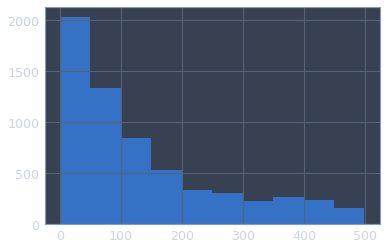

In [9]:
%%time
km = KMeans(n_clusters=500, init='k-means++', max_iter=200, n_init=10, verbose=0)
km.fit(icon_vals)
plt.hist(km.labels_)

In [10]:
icon_cluster500_table = pd.DataFrame.from_dict({'notif_id': icons_notif_ids, 'icon_kmeans500': km.labels_})

CPU times: user 25.6 s, sys: 1min 24s, total: 1min 50s
Wall time: 11.9 s


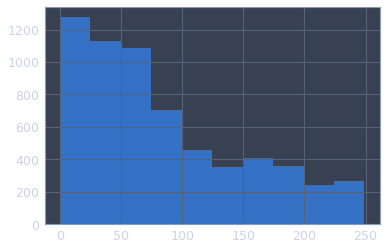

In [11]:
%%time
km = KMeans(n_clusters=250, init='k-means++', max_iter=200, n_init=10, verbose=0)
km.fit(icon_vals)
plt.hist(km.labels_)

In [12]:
icon_cluster250_table = pd.DataFrame.from_dict({'notif_id': icons_notif_ids, 'icon_kmeans250': km.labels_})

## Loading

In [13]:
notif_table = deca_load('notifs_generated') #ignore warning!
notif_table.words.fillna('-1', inplace=True) #replace NaN words with empty strings

loading data_hdf/_notifs_generated.h5... OK (0.0s)


## Add notif_send_week

In [14]:
notif_table = notif_table.sort_values('notif_id')
notif_table['notif_send_week'] = -1
notif_table.loc[(notif_table['notif_id']<462194) & (notif_table['notif_send_dow']==7),'notif_send_week'] = 0

notif_table.loc[(notif_table['notif_id']<462194) & (notif_table['notif_send_dow']!=7),'notif_send_week'] = 1

notif_table.loc[(notif_table['notif_id']>=457911) & 
           (notif_table['notif_id']<=472809) &
           (notif_table['notif_send_dow']==7)
           ,'notif_send_week'] = 1

notif_table.loc[(notif_table['notif_id']>=457911) & 
           (notif_table['notif_id']<=473484) &
           (notif_table['notif_send_dow']==1)
           ,'notif_send_week'] = 2

notif_table.loc[(notif_table['notif_id']>=465122) & 
           (notif_table['notif_id']<=515727) &
           (notif_table['notif_send_dow']!=7)
           ,'notif_send_week'] = 2

notif_table.loc[(notif_table['notif_id']>=504141) & 
           (notif_table['notif_id']<=532385) &
           (notif_table['notif_send_dow']==7)
           ,'notif_send_week'] = 2

notif_table.loc[(notif_table['notif_id']>=510200) & 
           (notif_table['notif_send_dow']==1)
           ,'notif_send_week'] = 3

notif_table.loc[(notif_table['notif_id']>=520098) & 
           (notif_table['notif_send_dow']!=7)
           ,'notif_send_week'] = 3
notif_table['notif_send_week'] = notif_table['notif_send_week'].astype(int)

## Adding icon and sentence

In [15]:
notif_table['sentenceC'] = notif_table['words'].apply(murmurhash3_32) 
notif_table['sentenceC'] = notif_table['sentenceC'].astype('category')
notif_table['sentenceC'] = notif_table['sentenceC'].cat.codes

In [16]:
notif_table = notif_table.merge(icons_hash_table, on='notif_id', how='left')
notif_table = notif_table.merge(icon_cluster250_table, on='notif_id', how='left')
notif_table = notif_table.merge(icon_cluster500_table, on='notif_id', how='left')
notif_table.icon_hash.fillna('-999', inplace=True)
notif_table.icon_kmeans250.fillna('-999', inplace=True)
notif_table.icon_kmeans500.fillna('-999', inplace=True)
notif_table['icon_hash'] = notif_table['icon_hash'].astype(int)
notif_table['icon_kmeans250'] = notif_table['icon_kmeans250'].astype(int)
notif_table['icon_kmeans500'] = notif_table['icon_kmeans500'].astype(int)

In [59]:
# notif_table['pair_sentence_icon'] = notif_table.apply(lambda row: murmurhash3_32('{}_{}'.format(row['sentenceC'], row['icon_hash'])), axis=1)

## Binning time (hour)

In [23]:
notif_table['notif_time_bin'] = notif_table.notif_send_hour.apply(get_hour_bin)

## Clustering notifications based on words

In [24]:
notif_ids = []
notif_sentences = []
for notif in notif_table.itertuples():
    sentence = ' '.join(notif.words.split('|'))
    notif_ids.append(notif.notif_id)
    notif_sentences.append(sentence)

CPU times: user 20.8 s, sys: 196 ms, total: 21 s
Wall time: 20.9 s


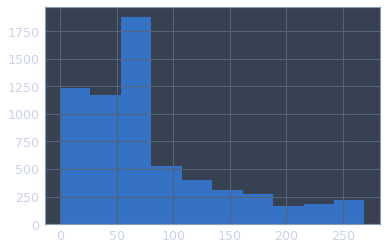

In [28]:
%%time
vectorizer = TfidfVectorizer(ngram_range=(1, 2))
vectorizer.fit(notif_sentences)
X_train_counts = vectorizer.transform(notif_sentences)
km = KMeans(n_clusters=270, init='k-means++', max_iter=100, n_init=10, verbose=0)
km.fit(X_train_counts)
plt.hist(km.labels_)

In [29]:
cluster_table = pd.DataFrame.from_dict({'notif_id': notif_ids, 'notif_kmeans': km.labels_})
notif_table = pd.merge(notif_table, cluster_table, on='notif_id', how='left')

CPU times: user 41.5 s, sys: 2.84 s, total: 44.3 s
Wall time: 44.2 s


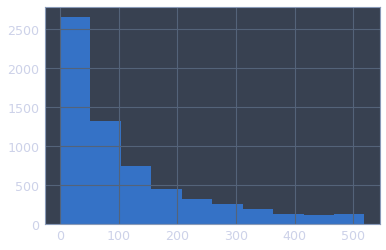

In [31]:
%%time
vectorizer = TfidfVectorizer(ngram_range=(1, 2))
vectorizer.fit(notif_sentences)
X_train_counts = vectorizer.transform(notif_sentences)
km = KMeans(n_clusters=520, init='k-means++', max_iter=100, n_init=10, verbose=0)
km.fit(X_train_counts)
plt.hist(km.labels_)

In [32]:
cluster_table = pd.DataFrame.from_dict({'notif_id': notif_ids, 'notif_kmeans520': km.labels_})
notif_table = pd.merge(notif_table, cluster_table, on='notif_id', how='left')

In [35]:
notif_table['words_count'] = notif_table.words.apply(lambda x: len(x.split('|')))

In [36]:
deca_save(notif_table, 'notifs_table_augmented')

saving data_hdf/_notifs_table_augmented.h5... OK (0.0s)


/home/nima_mohammadi/myenv/local/lib/python2.7/site-packages/pandas/core/generic.py:1471: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed-integer,key->block3_values] [items->['notif_id', 'words']]

  return pytables.to_hdf(path_or_buf, key, self, **kwargs)


In [68]:
# def create_aug_notif_features(train_tbl, notifs_tbl, field):
#     notifs = notifs_tbl[['notif_id', field]]
#     train = pd.merge(train_tbl, notifs, on='notif_id', how='left')
#     clicks_field = train.groupby(field).interaction.sum()
#     imps_field = train.groupby(field).interaction.count()
#     augtable = clicks_field.to_frame('clicks_{}'.format(field))
#     augtable = augtable.merge(imps_field.to_frame('imps_{}'.format(field)), left_index=True, right_index=True)
#     augtable = augtable.merge(notifs[field].value_counts().to_frame('dist_u_{}'.format(field)), left_index=True, right_index=True)
#     augtable['cr_{}'.format(field)] = augtable['clicks_{}'.format(field)] / augtable['imps_{}'.format(field)]
#     augtable['conf_{}'.format(field)] = np.log1p(augtable['imps_{}'.format(field)] / augtable['dist_u_{}'.format(field)])
#     augtable['cr_{}_bin'.format(field)] =  pd.qcut(augtable['cr_{}'.format(field)], 7)
#     augtable['cr_{}_bin'.format(field)] =  augtable['cr_{}_bin'.format(field)].cat.codes
#     augtable['conf_{}_bin'.format(field)] =  pd.qcut(augtable['conf_{}'.format(field)], 7)
#     augtable['conf_{}_bin'.format(field)] =  augtable['conf_{}_bin'.format(field)].cat.codes
#     return augtable
# train_table = deca_load('train_interactions')
# for field in ['notifC', 'notif_kmeans', 'notif_time_bin', ]:
#     print('Calculating CR and CONFIDENCE for {}'.format(field))
#     augt = create_aug_notif_features(train_table, notif_table, field)
#     notif_table = pd.merge(notif_table, augt, left_on=field, right_index=True, how='left')

## Adding raw notif time

In [10]:
def time_calc(row):
    t = row.notif_send_week * 7
    t = (t + (row.notif_send_dow - 1)) * 24
    return ((t + row.notif_send_hour) * 60) + row.notif_send_min

In [3]:
notifs_table_augmented = deca_load('notifs_table_augmented')

loading data_hdf/_notifs_table_augmented.h5... OK (0.3s)


In [4]:
notifs_table_augmented.head()

,notif_id,notif_send_dow,notif_send_hour,notif_send_min,notifC,words,notif_send_week,sentenceC,icon_hash,icon_kmeans250,icon_kmeans500,notif_time_bin,notif_kmeans,notif_kmeans520,words_count
0,406173,1,6,30,7,26|1291|1|141|114|34|1291|153|1209|13|26|1291|...,1,2,385,200,264,1,57,280,24
1,406289,1,6,44,7,26|1291|1|141|114|34|1291|153|1209|13|26|1291|...,1,2,1719,200,264,1,57,280,24
2,406320,1,6,56,7,26|1291|1|141|114|34|1291|153|1209|13|26|1291|...,1,2,1719,200,264,1,57,280,24
3,408582,1,9,30,7,403|181|1|606|8|6|1109|376|24|827,1,1094,122,65,125,2,162,289,10
4,410149,1,6,43,7,302|211|1|1350|203|13|1351|3|203|229|14,1,517,2489,203,225,1,194,165,11


In [12]:
notifs_table_augmented['notif_time_raw'] = notifs_table_augmented.apply(time_calc, axis=1)

In [16]:
deca_save(notifs_table_augmented, 'notifs_table_augmented')

saving data_hdf/_notifs_table_augmented.h5... OK (0.1s)


/home/nima_mohammadi/myenv/local/lib/python2.7/site-packages/pandas/core/generic.py:1471: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed-integer,key->block3_values] [items->['notif_id', 'words']]

  return pytables.to_hdf(path_or_buf, key, self, **kwargs)


# User Profile

## Users' Latent Factors

### Train and Valid

In [3]:
import scipy as sp
from sklearn.preprocessing import StandardScaler
import fbpca as fb
from sklearn.cluster import MiniBatchKMeans, KMeans

In [4]:
train_split = deca_load('train_split')
valid_split = deca_load('valid_split')
notif_ids = list(set(train_split.notif_id.unique()).union(valid_split.notif_id.unique()))
tbl_trn = train_split
tbl_tst = valid_split

loading data_hdf/_train_split.h5... OK (3.9s)
loading data_hdf/_valid_split.h5... OK (0.4s)


In [5]:
tbl_tst['interaction'] = 1
tbl_trn.loc[tbl_trn.interaction==1, 'interaction'] = 2
tbl_trn.loc[tbl_trn.interaction==0, 'interaction'] = 1
tbl_joined = pd.concat([tbl_trn, tbl_tst])
tbl_joined = tbl_joined[['user_id', 'notif_id', 'interaction']]

user_ids = list(tbl_joined.user_id.unique())
notif_ids = list(tbl_joined.notif_id.unique())

notif_ids_map = {j: i for i, j in enumerate(notif_ids)}
user_ids_map = {j: i for i, j in enumerate(user_ids)}

notif_ids_map_rev = {j: i for i, j in notif_ids_map.iteritems()}
user_ids_map_rev = {j: i for i, j in user_ids_map.iteritems()}

notif_ids_mapping = pd.DataFrame(notif_ids_map.items()).set_index(0).iloc[:,0]
user_ids_mapping = pd.DataFrame(user_ids_map.items()).set_index(0).iloc[:,0]

In [6]:
tbl_joined['nid'] = tbl_joined.notif_id.map(notif_ids_mapping)
tbl_joined['uid'] = tbl_joined.user_id.map(user_ids_mapping)

In [7]:
ratings_split = sp.sparse.csr_matrix((tbl_joined.loc[:, 'interaction'], (tbl_joined.loc[:, 'uid'], tbl_joined.loc[:, 'nid'])))
scaler = StandardScaler(with_mean=False)
scaled_ratings_split = scaler.fit_transform(ratings_split)

/home/nima_mohammadi/myenv/local/lib/python2.7/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [8]:
n_comps = 10

In [9]:
%%time
# U, mu, V = fb.pca(ratings_split, n_comps, raw=True, n_iter=30)
U_scale, mu_scale, V_scale = fb.pca(scaled_ratings_split, n_comps, raw=True, n_iter=30)

CPU times: user 1min 27s, sys: 1min 47s, total: 3min 15s
Wall time: 1min 16s


In [10]:
# UsvdSplitOrig = pd.DataFrame(U, index=[user_ids_map_rev[i] for i in range(U.shape[0])], columns=['USVD{}'.format(i) for i in range(U.shape[1])])
UsvdSplitScaled = pd.DataFrame(U_scale, index=[user_ids_map_rev[i] for i in range(U_scale.shape[0])], columns=['USVD{}'.format(i) for i in range(U_scale.shape[1])])
# VsvdSplitOrig = pd.DataFrame(V.T, index=[notif_ids_map_rev[i] for i in range(V.T.shape[0])], columns=['VSVD{}'.format(i) for i in range(V.T.shape[1])])
VsvdSplitScaled = pd.DataFrame(V_scale.T, index=[notif_ids_map_rev[i] for i in range(V_scale.T.shape[0])], columns=['VSVD{}'.format(i) for i in range(V_scale.T.shape[1])])

In [11]:
%%time
km = MiniBatchKMeans(n_clusters=150, max_iter=400, n_init=7, verbose=0, max_no_improvement=40)
km.fit(U_scale)
UsvdSplitScaled['Usvd_kmeans150'] = km.labels_

CPU times: user 10.8 s, sys: 116 ms, total: 10.9 s
Wall time: 10.9 s


In [12]:
%%time
km = KMeans(n_clusters=111, init='k-means++', max_iter=100, n_init=10, verbose=0)
km.fit(V_scale.T)
VsvdSplitScaled['Vsvd_kmeans111'] = km.labels_

CPU times: user 6.81 s, sys: 39.2 s, total: 46 s
Wall time: 1.44 s


In [13]:
# deca_save(UsvdSplitOrig, 'UsvdSplitOrig')
deca_save(UsvdSplitScaled, 'UsvdSplitScaled')
# deca_save(VsvdSplitOrig, 'VsvdSplitOrig')
deca_save(VsvdSplitScaled, 'VsvdSplitScaled')

saving data_hdf/_UsvdSplitScaled.h5... OK (2.2s)
saving data_hdf/_VsvdSplitScaled.h5... OK (0.1s)


### Full Train

In [3]:
import scipy as sp
from sklearn.preprocessing import StandardScaler
import fbpca as fb
from sklearn.cluster import MiniBatchKMeans, KMeans

In [4]:
full_train_table = deca_load('train_interactions').reset_index(drop=True)
test = deca_load('test').reset_index(drop=True)
notif_ids = list(set(full_train_table.notif_id.unique()).union(test.notif_id.unique()))
tbl_trn = full_train_table
tbl_tst = test

loading data_hdf/_train_interactions.h5... OK (6.6s)
loading data_hdf/_test.h5... OK (0.2s)


In [5]:
tbl_tst['interaction'] = 1
tbl_trn.loc[tbl_trn.interaction==1, 'interaction'] = 2
tbl_trn.loc[tbl_trn.interaction==0, 'interaction'] = 1
tbl_joined = pd.concat([tbl_trn, tbl_tst])
tbl_joined = tbl_joined[['user_id', 'notif_id', 'interaction']]

user_ids = list(tbl_joined.user_id.unique())
notif_ids = list(tbl_joined.notif_id.unique())

notif_ids_map = {j: i for i, j in enumerate(notif_ids)}
user_ids_map = {j: i for i, j in enumerate(user_ids)}

notif_ids_map_rev = {j: i for i, j in notif_ids_map.iteritems()}
user_ids_map_rev = {j: i for i, j in user_ids_map.iteritems()}

notif_ids_mapping = pd.DataFrame(notif_ids_map.items()).set_index(0).iloc[:,0]
user_ids_mapping = pd.DataFrame(user_ids_map.items()).set_index(0).iloc[:,0]

In [6]:
tbl_joined['nid'] = tbl_joined.notif_id.map(notif_ids_mapping)
tbl_joined['uid'] = tbl_joined.user_id.map(user_ids_mapping)

In [7]:
ratings_full = sp.sparse.csr_matrix((tbl_joined.loc[:, 'interaction'], (tbl_joined.loc[:, 'uid'], tbl_joined.loc[:, 'nid'])))
scaler = StandardScaler(with_mean=False)
scaled_ratings_full = scaler.fit_transform(ratings_full)

/home/nima_mohammadi/myenv/local/lib/python2.7/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [8]:
n_comps = 10

In [9]:
%%time
U_scale, mu_scale, V_scale = fb.pca(scaled_ratings_full, n_comps, raw=True, n_iter=30)

CPU times: user 2min 20s, sys: 2min 10s, total: 4min 31s
Wall time: 2min 8s


In [10]:
UsvdFullScaled = pd.DataFrame(U_scale, index=[user_ids_map_rev[i] for i in range(U_scale.shape[0])], columns=['USVD{}'.format(i) for i in range(U_scale.shape[1])])
VsvdFullScaled = pd.DataFrame(V_scale.T, index=[notif_ids_map_rev[i] for i in range(V_scale.T.shape[0])], columns=['VSVD{}'.format(i) for i in range(V_scale.T.shape[1])])

In [11]:
%%time
km = MiniBatchKMeans(n_clusters=150, max_iter=400, n_init=7, verbose=0, max_no_improvement=40)
km.fit(U_scale)
UsvdFullScaled['Usvd_kmeans150'] = km.labels_

CPU times: user 16.3 s, sys: 148 ms, total: 16.5 s
Wall time: 16.5 s


In [12]:
%%time
km = KMeans(n_clusters=111, init='k-means++', max_iter=100, n_init=10, verbose=0)
km.fit(V_scale.T)
VsvdFullScaled['Vsvd_kmeans111'] = km.labels_

CPU times: user 7.05 s, sys: 38.1 s, total: 45.1 s
Wall time: 1.43 s


In [13]:
deca_save(UsvdFullScaled, 'UsvdFullScaled')
deca_save(VsvdFullScaled, 'VsvdFullScaled')

saving data_hdf/_UsvdFullScaled.h5... OK (1.7s)
saving data_hdf/_VsvdFullScaled.h5... OK (0.0s)


## User-Notif similarity based on words (disabled)

In [3]:
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy import linalg, dot

In [4]:
notif_table = deca_load('notifs_generated') #ignore warning!
notif_table.words.fillna('-1', inplace=True) #replace NaN words with empty strings

loading data_hdf/_notifs_generated.h5... OK (0.3s)


In [39]:
notif_ids = []
notif_sentences = []
notif_table = notif_table.sort_values('notif_id')
for notif in notif_table.itertuples():
    sentence = ' '.join(notif.words.split('|'))
    notif_ids.append(notif.notif_id)
    notif_sentences.append(sentence)
vectorizer = TfidfVectorizer(min_df=.00065, max_df=.1, sublinear_tf = True) # max_features=200, ngram_range=(0,3)
vectorizer.fit(notif_sentences)
notif_prof = vectorizer.transform(notif_sentences).todense()

In [49]:
import sklearn.metrics

In [50]:
def similarity_users_notifs(tbl, notif_ids, notif_prof):
    interacts = tbl[tbl.interaction==1][['user_id', 'notif_id', 'interaction']]
    interacts = interacts.append([{'user_id': -1, 'notif_id': nid, 'interaction': 0} for nid in notif_ids])
    interacts = pd.pivot_table(interacts, index='user_id', columns='notif_id', values='interaction').fillna(0)
    interacts.drop(-1, inplace=True)
    print('Calculating user profiles')
    user_prof = dot(interacts.values, notif_prof) / linalg.norm(interacts.values) / linalg.norm(notif_prof)
    print('Calculating cosine similarity')
    similarity_user_notif = sklearn.metrics.pairwise.cosine_similarity(user_prof, notif_prof)
    print('Converting to dataframe')
    similarity_user_notif_df = pd.DataFrame(data=similarity_user_notif, index=interacts.index, columns=interacts.columns)
    return similarity_user_notif_df
#     similarity_user_notif_df['user_id'] = interacts.index
#     return pd.melt(similarity_user_notif_df, id_vars='user_id', value_vars=list(similarity_user_notif_df.columns[:-1]), value_name='similarity')

### TRAIN VALID SPLIT

In [13]:
train_split = deca_load('train_split')
valid_split = deca_load('valid_split')

loading data_hdf/_train_split.h5... OK (14.4s)
loading data_hdf/_valid_split.h5... OK (1.3s)


In [51]:
%%time
train_split_user_notif_similarity = similarity_users_notifs(train_split, notif_ids, notif_prof)

CPU times: user 1h 49min 38s, sys: 9min 20s, total: 1h 58min 59s
Wall time: 16min 37s


In [55]:
train_split_user_notif_similarity.shape

(1066051, 6347)

In [56]:
%%time
train_split['uid_nid'] = train_split.user_id * 700000 + train_split.notif_id
valid_split['uid_nid'] = valid_split.user_id * 700000 + valid_split.notif_id

CPU times: user 3.02 s, sys: 392 ms, total: 3.42 s
Wall time: 683 ms


In [57]:
%%time
similarity_dict = {}
simil_uid_indices = set(train_split_user_notif_similarity.index)
for uidnid in set(train_split.uid_nid.unique()).union(valid_split.uid_nid.unique()):
    uid = uidnid // 700000
    if uid in simil_uid_indices:
        nid = uidnid % 700000
        similarity_dict[uidnid] = train_split_user_notif_similarity.loc[uid,nid]

CPU times: user 15min 36s, sys: 24.1 s, total: 16min
Wall time: 15min 53s


In [58]:
%%time
valid_split['user_notif_similarity'] = valid_split.uid_nid.map(similarity_dict)

CPU times: user 39.1 s, sys: 1.28 s, total: 40.4 s
Wall time: 40.4 s


In [59]:
%%time
train_split['user_notif_similarity'] = train_split.uid_nid.map(similarity_dict)

CPU times: user 47.7 s, sys: 2.93 s, total: 50.7 s
Wall time: 50.7 s


In [60]:
deca_save(train_split.user_notif_similarity, 'user_notif_similarity')
deca_save(valid_split.user_notif_similarity, 'user_notif_similarity_val')

saving data_hdf/_user_notif_similarity.h5... OK (6.0s)
saving data_hdf/_user_notif_similarity_val.h5... OK (0.5s)


### FULL TRAIN AND TEST

In [9]:
full_train_table = deca_load('train_interactions')
test_table = deca_load('test')

loading data_hdf/_train_interactions.h5... OK (22.5s)
loading data_hdf/_test.h5... OK (1.1s)


In [10]:
%%time
full_train_user_notif_similarity = similarity_users_notifs(full_train_table, notif_ids, notif_prof)

CPU times: user 50min 25s, sys: 14min 18s, total: 1h 4min 43s
Wall time: 25min 58s


In [11]:
%%time
full_train_table['uid_nid'] = full_train_table.user_id * 700000 + full_train_table.notif_id
test_table['uid_nid'] = test_table.user_id * 700000 + test_table.notif_id

CPU times: user 3.63 s, sys: 884 ms, total: 4.51 s
Wall time: 1.07 s


In [38]:
%%time
similarity_dict = {}
simil_uid_indices = set(full_train_user_notif_similarity.index)
for uidnid in set(full_train_table.uid_nid.unique()).union(test_table.uid_nid.unique()):
    uid = uidnid // 700000
    if uid in simil_uid_indices:
        nid = uidnid % 700000
        similarity_dict[uidnid] = full_train_user_notif_similarity.loc[uid,nid]

# Split to train and validation

In [39]:
SAVE = False

full_train_table = deca_load('train_interactions')
test_table = deca_load('test')

valid_split = full_train_table[full_train_table['notif_id'] > 518000]
train_split = full_train_table[full_train_table['notif_id'] <= 518000]
users_val = set(valid_split.user_id.unique().tolist())
users_trn = set(train_split.user_id.unique().tolist())
train_users_to_remove = list(users_val.intersection(users_trn))[:900000]
train_split = train_split[~train_split['user_id'].isin(train_users_to_remove)]

if SAVE:
    deca_save(train_split, 'train_split')
    deca_save(valid_split, 'valid_split')

print('Fulltrain rows:', full_train_table.shape[0])
print('Test rows:', test_table.shape[0])
print('-'*10)
print('Train_split rows:', train_split.shape[0])
print('Valid_split rows:', valid_split.shape[0])

loading data_hdf/_train_interactions.h5... OK (22.3s)
loading data_hdf/_test.h5... OK (0.9s)
Fulltrain rows: 98403133
Test rows: 10928823
----------
Train_split rows: 56762338
Valid_split rows: 5499040


## Stats for train and test

In [40]:
fsc = full_train_table['user_id'].count()
tsc = train_split['user_id'].count()
vsc = valid_split['user_id'].count()
print('Total train records: {} ({})'.format(tsc, tsc/fsc))
print('Total valid records: {} ({})'.format(vsc, vsc/fsc))

Total train records: 56762338 (0.576834662368)
Total valid records: 5499040 (0.0558827735698)


In [41]:
users_test = set(test_table.user_id.unique())
notifs_test = set(test_table.notif_id.unique())

users_full_train = set(full_train_table.user_id.unique())
notifs_full_train = set(full_train_table.notif_id.unique())

all_users = users_full_train.union(users_test)
all_notifs = notifs_full_train.union(notifs_test)

user_p = len(users_full_train.intersection(users_test))
notif_p = len(notifs_full_train.intersection(notifs_test))
user_p2 = len(users_full_train - users_test)
notif_p2 = len(notifs_full_train - notifs_test)
user_p3 = len(users_test - users_full_train)
notif_p3 = len(notifs_test - notifs_full_train)

In [42]:
users_valid = set(valid_split.user_id.unique())
users_train = set(train_split.user_id.unique())

notifs_valid = set(valid_split.notif_id.unique())
notifs_train = set(train_split.notif_id.unique())

user_q = len(users_train.intersection(users_valid))
notif_q = len(notifs_train.intersection(notifs_valid))
user_q2 = len(users_train - users_valid)
notif_q2 = len(notifs_train - notifs_valid)
user_q3 = len(users_valid - users_train)
notif_q3 = len(notifs_valid - notifs_train)

print('Common users TEST and FULLTRN:\t{}\t{}'.format(user_p, user_p / len(all_users)))
print('Common users VALID and TRAIN:\t{}\t{}'.format(user_q, user_q / len(users_full_train)))
print('-' * 20)
print('users on FULLTRN', len(users_full_train))
print('users on TEST', len(users_test))
print('users on TRAIN', len(users_train))
print('users on VALID', len(users_valid))
print('-' * 20)
print('users only on FULLTRN:\t{}\t{}'.format(user_p2, user_p2 / len(all_users)))
print('users only on TEST:\t{}\t{}'.format(user_p3, user_p3 / len(all_users)))
print('users only on TRAIN:\t{}\t{}'.format(user_q2, user_q2 / len(users_full_train)))
print('users only on VALID:\t{}\t{}'.format(user_q3, user_q3 / len(users_full_train)))
print('\n')
print('Common notifs TEST and FULLTRN:\t{}\t{}'.format(notif_p, notif_p / len(all_notifs)))
print('Common notifs VALID and TRAIN:\t{}\t{}'.format(notif_q, notif_q / len(notifs_full_train)))
print('-' * 20)
print('notifs on FULLTRN', len(notifs_full_train))
print('notifs on TEST', len(notifs_test))
print('notifs on TRAIN', len(notifs_train))
print('notifs on VALID', len(notifs_valid))
print('-' * 20)
print('notifs only on FULLTRN:\t{}\t{}'.format(notif_p2, notif_p2 / len(all_notifs)))
print('notifs only on TRAIN:\t{}\t{}'.format(notif_q2, notif_q2 / len(notifs_full_train)))
print('notifs only on TEST:\t{}\t{}'.format(notif_p3, notif_p3 / len(all_notifs)))
print('notifs only on VALID:\t{}\t{}'.format(notif_q3, notif_q3 / len(notifs_full_train)))

Common users TEST and FULLTRN:	2030753	0.506433055672
Common users VALID and TRAIN:	972962	0.375764593019
--------------------
users on FULLTRN 2589286
users on TEST 3451381
users on TRAIN 1689286
users on VALID 1872962
--------------------
users only on FULLTRN:	558533	0.139288024631
users only on TEST:	1420628	0.354278919698
users only on TRAIN:	716324	0.276649238439
users only on VALID:	900000	0.347586168542


Common notifs TEST and FULLTRN:	0	0.0
Common notifs VALID and TRAIN:	0	0.0
--------------------
notifs on FULLTRN 4440
notifs on TEST 189
notifs on TRAIN 4156
notifs on VALID 284
--------------------
notifs only on FULLTRN:	4440	0.959170447181
notifs only on TRAIN:	4156	0.936036036036
notifs only on TEST:	189	0.0408295528192
notifs only on VALID:	284	0.063963963964


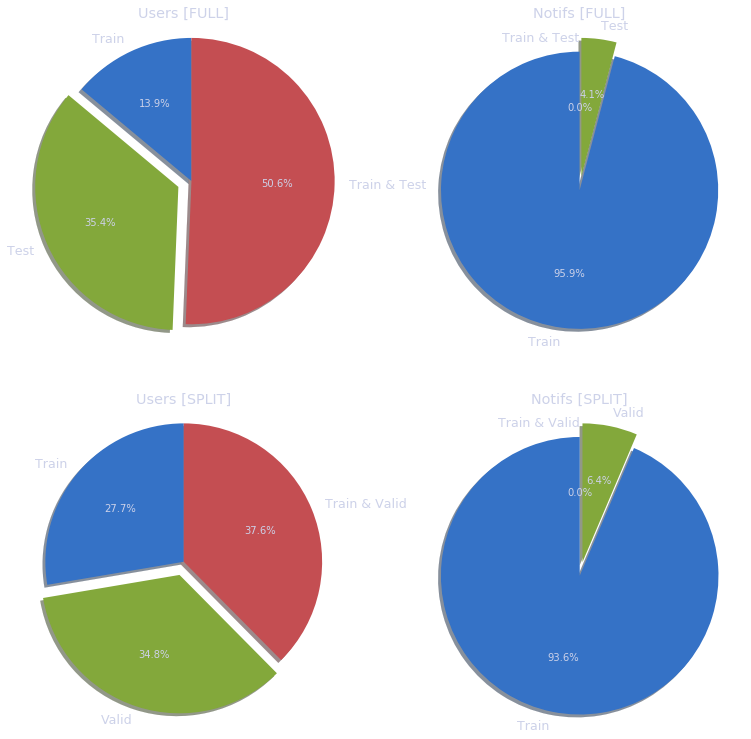

In [43]:
labels_full = 'Train', 'Test', 'Train & Test'
sizes_full_u = [user_p2, user_p3, user_p]
sizes_full_n = [notif_p2, notif_p3, notif_p]

labels_split = 'Train', 'Valid', 'Train & Valid'
sizes_split_u = [user_q2, user_q3, user_q]
sizes_split_n = [notif_q2, notif_q3, notif_q]

explode = (0, 0.1, 0)  # only "explode" the 2nd slice (i.e. 'Hogs')

f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2)

f.set_figheight(13)
f.set_figwidth(13)

ax1.set_title('Users [FULL]')
ax1.pie(sizes_full_u, explode=explode, labels=labels_full, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal') 

ax2.set_title('Notifs [FULL]')
ax2.pie(sizes_full_n, explode=explode, labels=labels_full, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax2.axis('equal') 

ax3.set_title('Users [SPLIT]')
ax3.pie(sizes_split_u, explode=explode, labels=labels_split, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax3.axis('equal') 

ax4.set_title('Notifs [SPLIT]')
ax4.pie(sizes_split_n, explode=explode, labels=labels_split, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax4.axis('equal') 

plt.show()

# Augmenting with History

## User Imps

In [3]:
full_train = deca_load('train_interactions')[['user_id', 'notif_id']]
test = deca_load('test')[['user_id', 'notif_id']]

loading data_hdf/_train_interactions.h5... OK (7.8s)
loading data_hdf/_test.h5... OK (0.2s)


In [4]:
concat_train_test = pd.concat([full_train, test])

In [6]:
joinints = lambda x: tuple(set(x))

In [7]:
%%time
users_notifs = concat_train_test.groupby('user_id').notif_id.agg(joinints)

CPU times: user 2min 18s, sys: 5.98 s, total: 2min 24s
Wall time: 2min 23s


In [8]:
users_notifs_imps = users_notifs.to_frame()
users_notifs_imps = users_notifs_imps.reset_index()
users_notifs_imps = users_notifs_imps.rename(columns={'user_id': 'user_id', 'notif_id': 'imps'})

In [10]:
deca_save(users_notifs_imps, 'users_notifs_imps')

saving data_hdf/_users_notifs_imps.h5... 

/home/nima_mohammadi/myenv/local/lib/python2.7/site-packages/pandas/core/generic.py:1471: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block0_values] [items->['imps']]

  return pytables.to_hdf(path_or_buf, key, self, **kwargs)


OK (12.2s)


In [13]:
ww = valid_split.groupby('user_id').notif_id.count()

In [14]:
ww.head()

user_id
3    1
4    4
7    4
8    4
9    6
Name: notif_id, dtype: int64

## Notif time diff to prev and next notif

In [117]:
def priximity_notif_time_diff(tbl, order='prev_diff', history=None):
    N = 150
    alpha = list(np.logspace(-.3, -2.01, 110))
    if order=='prev_diff':
        tbl = tbl.sort_values('notif_time_raw')
        col1 = 'prev_time_diff'
        col2 = 'prev_nid'
        col3 = 'prev_hour_imps'
        col4 = 'prev_day_imps'
        col5 = 'prev_3hours_imps'
        last_clicks_flag = True
    else:
        tbl = tbl.sort_values('notif_time_raw', ascending=False)
        col1 = 'next_time_diff'
        col2 = 'next_nid'
        col3 = 'next_hour_imps'
        col4 = 'next_day_imps'
        col5 = 'next_3hours_imps'
        last_clicks_flag = False
    uids = list(tbl.user_id.unique())
    if history is not None:
        last_notif_time_dict = history['last_notif_time_dict']
        last_nid_dict = history['last_nid_dict']
        last_imps = history['last_imps']
        last_imps_day_pointer = history['last_imps_day_pointer']
        last_imps_hour_pointer = history['last_imps_hour_pointer']
        last_imps_3hours_pointer = history['last_imps_3hours_pointer']
        last_imps_len = history['last_imps_len']
        last_click_first_dict = history['last_click_first_dict']
        last_click_second_dict = history['last_click_second_dict']
        last_click_third_dict = history['last_click_third_dict']
        last_click_fourth_dict = history['last_click_fourth_dict']
        last_click_first_diff_dict = history['last_click_first_diff_dict']
        last_click_second_diff_dict = history['last_click_second_diff_dict']
        last_click_third_diff_dict = history['last_click_third_diff_dict']
        last_click_fourth_diff_dict = history['last_click_fourth_diff_dict']
        last_click_fifth_diff_dict = history['last_click_fifth_diff_dict']
        movAvgRt_dict = history['movAvgRt_dict']
        flag = False
    else:
        last_notif_time_dict = {}
        last_nid_dict = {}
        last_imps = defaultdict(lambda: [0] * N)
        last_imps_day_pointer = defaultdict(int)
        last_imps_hour_pointer = defaultdict(int)
        last_imps_3hours_pointer = defaultdict(int)
        last_imps_len = defaultdict(int)
        last_click_first_dict = {}
        last_click_second_dict = {}
        last_click_third_dict = {}
        last_click_fourth_dict = {}
        last_click_first_diff_dict = {}
        last_click_second_diff_dict = {}
        last_click_third_diff_dict = {}
        last_click_fourth_diff_dict = {}
        last_click_fifth_diff_dict = {}
        movAvgRt_dict = {}
        flag = True
    try:
        tbl = tbl[['user_id', 'notif_id', 'notif_time_raw', 'response_time', 'interaction']]
    except:
        tbl = tbl[['user_id', 'notif_id', 'notif_time_raw']]
    last_time_diff = []
    last_notif = []
    indices = []
    last_hour_imps_count = []
    last_3hours_imps_count = []
    last_day_imps_count = []
    last_click_first = []
    last_click_first_diff = []
    last_click_second = []
    last_click_second_diff = []
    last_click_third = []
    last_click_third_diff = []
    last_click_fourth = []
    last_click_fourth_diff = []
    last_click_fifth_diff = []
    last_movAvgRt = []
    length = tbl.shape[0]
    for row in tqdm(tbl.itertuples(), total=length, mininterval=4):
        uid = row.user_id
        nid = row.notif_id
        notif_time_raw = row.notif_time_raw
        if last_clicks_flag:
            prevRT = movAvgRt_dict.get(uid, None)
            last_click_first.append(last_click_first_dict.get(uid, None))
            last_click_second.append(last_click_second_dict.get(uid, None))
            last_click_third.append(last_click_third_dict.get(uid, None))
            last_click_fourth.append(last_click_fourth_dict.get(uid, None))
            
            last_click_second_diff.append(last_click_second_diff_dict.get(uid, None) and (last_click_first_diff_dict.get(uid, None) - last_click_second_diff_dict.get(uid, None)))
            last_click_third_diff.append(last_click_third_diff_dict.get(uid, None) and (last_click_second_diff_dict.get(uid, None) - last_click_third_diff_dict.get(uid, None)))
            last_click_fourth_diff.append(last_click_fourth_diff_dict.get(uid, None) and (last_click_third_diff_dict.get(uid, None) - last_click_fourth_diff_dict.get(uid, None)))
            last_click_fifth_diff.append(last_click_fifth_diff_dict.get(uid, None) and (last_click_fourth_diff_dict.get(uid, None) - last_click_fifth_diff_dict.get(uid, None)))
            last_movAvgRt.append(prevRT)
            if flag:
                curAlpha = alpha[last_imps_len[uid]]
                curRT = (curAlpha*row.response_time) + ((1-curAlpha) * movAvgRt_dict.get(uid, row.response_time))
                movAvgRt_dict[uid] = curRT
                if row.interaction:
                    last_click_fourth_dict[uid] = last_click_third_dict.get(uid, None)
                    last_click_third_dict[uid] = last_click_second_dict.get(uid, None)
                    last_click_second_dict[uid] = last_click_first_dict.get(uid, None)
                    last_click_first_dict[uid] = nid
                    
                    last_click_fifth_diff_dict[uid] = last_click_fourth_diff_dict.get(uid, None)
                    last_click_fourth_diff_dict[uid] = last_click_third_diff_dict.get(uid, None)
                    last_click_third_diff_dict[uid] = last_click_second_diff_dict.get(uid, None)
                    last_click_second_diff_dict[uid] = last_click_first_diff_dict.get(uid, None)
                    last_click_first_diff_dict[uid] = notif_time_raw
                    
        temp_last_imps = last_imps[uid]
        last_imps[uid][last_imps_len[uid]] = notif_time_raw
        last_imps_len[uid] += 1
        
        if last_clicks_flag:
            last_time_diff.append(notif_time_raw - last_notif_time_dict.get(uid, notif_time_raw+1))
            last_hour_limit = notif_time_raw - 60
            last_day_limit = notif_time_raw - 1440
            last_3hours_limit = notif_time_raw - 180
            for last_imps_hour_pointer[uid] in xrange(last_imps_hour_pointer[uid], last_imps_len[uid]+1):
                if temp_last_imps[last_imps_hour_pointer[uid]] > last_hour_limit:
                    break
            for last_imps_day_pointer[uid] in xrange(last_imps_day_pointer[uid], last_imps_len[uid]+1):
                if temp_last_imps[last_imps_day_pointer[uid]] > last_day_limit:
                    break
            for last_imps_3hours_pointer[uid] in xrange(last_imps_3hours_pointer[uid], last_imps_len[uid]+1):
                if temp_last_imps[last_imps_3hours_pointer[uid]] > last_3hours_limit:
                    break
        else:
            last_time_diff.append(last_notif_time_dict.get(uid, notif_time_raw-1) - notif_time_raw)
            last_hour_limit = notif_time_raw + 60
            last_day_limit = notif_time_raw + 1440
            last_3hours_limit = notif_time_raw + 180
            for last_imps_hour_pointer[uid] in xrange(last_imps_hour_pointer[uid], last_imps_len[uid]+1):
                if temp_last_imps[last_imps_hour_pointer[uid]] < last_hour_limit:
                    break
            for last_imps_day_pointer[uid] in xrange(last_imps_day_pointer[uid], last_imps_len[uid]+1):
                if temp_last_imps[last_imps_day_pointer[uid]] < last_day_limit:
                    break
            for last_imps_3hours_pointer[uid] in xrange(last_imps_3hours_pointer[uid], last_imps_len[uid]+1):
                if temp_last_imps[last_imps_3hours_pointer[uid]] < last_3hours_limit:
                    break
        
        last_hour_imps_count.append(last_imps_len[uid] - last_imps_hour_pointer[uid] - 1)
        last_day_imps_count.append(last_imps_len[uid] - last_imps_day_pointer[uid] - 1)
        last_3hours_imps_count.append(last_imps_len[uid] - last_imps_3hours_pointer[uid] - 1)
        
        indices.append(row.Index)
        last_notif.append(last_nid_dict.get(uid, None))
        last_notif_time_dict[uid] = row.notif_time_raw
        last_nid_dict[uid] = row.notif_id
        resdict = {'ind': indices, col1: last_time_diff, 
                                   col2: last_notif, col3: last_hour_imps_count,
                                   col4: last_day_imps_count, col5: last_3hours_imps_count
                  }
        if last_clicks_flag:
            resdict['last_click_1st'] = last_click_first
            resdict['last_click_2nd'] = last_click_second
            resdict['last_click_3rd'] = last_click_third
            resdict['last_click_4th'] = last_click_fourth
            resdict['last_click_2nd_diff'] = last_click_second_diff
            resdict['last_click_3rd_diff'] = last_click_third_diff
            resdict['last_click_4th_diff'] = last_click_fourth_diff
            resdict['last_click_5th_diff'] = last_click_fifth_diff
            resdict['movAvgRt'] = last_movAvgRt
    return pd.DataFrame.from_dict(resdict).set_index('ind'), {
            'last_notif_time_dict': last_notif_time_dict, 
            'last_nid_dict': last_nid_dict, 
            'last_imps': last_imps, 
            'last_imps_len': last_imps_len, 
            'last_imps_day_pointer': last_imps_day_pointer, 
            'last_imps_hour_pointer': last_imps_hour_pointer, 
            'last_imps_3hours_pointer': last_imps_3hours_pointer, 
            'last_click_first_dict': last_click_first_dict, 
            'last_click_second_dict': last_click_second_dict, 
            'last_click_third_dict': last_click_third_dict, 
            'last_click_fourth_dict': last_click_fourth_dict,
            'last_click_first_diff_dict': last_click_first_diff_dict, 
            'last_click_second_diff_dict': last_click_second_diff_dict, 
            'last_click_third_diff_dict': last_click_third_diff_dict, 
            'last_click_fourth_diff_dict': last_click_fourth_diff_dict,
            'last_click_fifth_diff_dict': last_click_fifth_diff_dict,
            'movAvgRt_dict' : movAvgRt_dict
    }

In [49]:
full_train_table = deca_load('train_interactions').reset_index(drop=True)
test_table = deca_load('test').reset_index(drop=True)
train_split = deca_load('train_split').reset_index(drop=True)
valid_split = deca_load('valid_split').reset_index(drop=True)
notif_table = deca_load('notifs_table_augmented')

loading data_hdf/_train_interactions.h5... OK (6.8s)
loading data_hdf/_test.h5... OK (0.2s)
loading data_hdf/_train_split.h5... OK (4.0s)
loading data_hdf/_valid_split.h5... OK (0.4s)
loading data_hdf/_notifs_table_augmented.h5... OK (0.0s)


In [50]:
def time_diff_calc_tbl(tbl):
    diff_day = (tbl.interaction_dow - tbl.delivery_dow) % 7
    diff_time = (tbl.interaction_hour * 60 + tbl.interaction_min) - (tbl.delivery_hour * 60 + tbl.delivery_min)
    return abs((diff_day * 24 * 60) + diff_time)
train_split['response_time'] = time_diff_calc_tbl(train_split)
full_train_table['response_time'] = time_diff_calc_tbl(full_train_table)

In [51]:
%%time
train_split = pd.merge(train_split[['user_id', 'notif_id', 'interaction', 'response_time']], notif_table[['notif_id', 'notif_time_raw']], on='notif_id', how='left')
valid_split = pd.merge(valid_split[['user_id', 'notif_id']], notif_table[['notif_id', 'notif_time_raw']], on='notif_id', how='left')
full_train_table = pd.merge(full_train_table[['user_id', 'notif_id', 'interaction', 'response_time']], notif_table[['notif_id', 'notif_time_raw']], on='notif_id', how='left')
test_table = pd.merge(test_table[['user_id', 'notif_id']], notif_table[['notif_id', 'notif_time_raw']], on='notif_id', how='left')

In [131]:
# q, w = priximity_notif_time_diff(train_split[train_split.user_id==10387291])
# q2, w = priximity_notif_time_diff(valid_split[valid_split.user_id==10387291], 'prev_diff', w)
# pd.concat([valid_split[valid_split.user_id==10387291], q2], axis=1).sort_values('notif_time_raw')
# pd.concat([train_split[train_split.user_id==10387291], q], axis=1).sort_values('notif_time_raw').tail(5)

In [133]:
prev_diff_train, history = priximity_notif_time_diff(train_split)

HBox(children=(IntProgress(value=0, max=56762338), HTML(value=u'')))

In [134]:
prev_diff_valid, history = priximity_notif_time_diff(valid_split, 'prev_diff', history)

HBox(children=(IntProgress(value=0, max=5499040), HTML(value=u'')))

In [135]:
next_diff_valid, history = priximity_notif_time_diff(valid_split, 'next_diff')

HBox(children=(IntProgress(value=0, max=5499040), HTML(value=u'')))

In [136]:
next_diff_train, history = priximity_notif_time_diff(train_split, 'next_diff', history)

HBox(children=(IntProgress(value=0, max=56762338), HTML(value=u'')))

In [137]:
deca_save(pd.concat([prev_diff_train, next_diff_train], axis=1), 'history_train')
deca_save(pd.concat([prev_diff_valid, next_diff_valid], axis=1), 'history_valid')

saving data_hdf/_history_train.h5... OK (74.8s)
saving data_hdf/_history_valid.h5... OK (6.1s)


In [138]:
del prev_diff_train, next_diff_train, prev_diff_valid, next_diff_valid, history
import gc
gc.collect()

93

In [140]:
prev_diff_ftrain, history = priximity_notif_time_diff(full_train_table)

HBox(children=(IntProgress(value=0, max=98403133), HTML(value=u'')))

In [141]:
prev_diff_test, history = priximity_notif_time_diff(test_table, 'prev_diff', history)

HBox(children=(IntProgress(value=0, max=10928823), HTML(value=u'')))

In [ ]:
next_diff_test, history = priximity_notif_time_diff(test_table, 'next_diff')

HBox(children=(IntProgress(value=0, max=10928823), HTML(value=u'')))

In [ ]:
next_diff_ftrain, history = priximity_notif_time_diff(full_train_table, 'next_diff', history)

HBox(children=(IntProgress(value=0, max=98403133), HTML(value=u'')))

In [ ]:
deca_save(pd.concat([prev_diff_ftrain, next_diff_ftrain], axis=1), 'history_ftrain')
deca_save(pd.concat([prev_diff_test, next_diff_test], axis=1), 'history_test')

In [389]:
aaa = pd.concat([full_train_table, prev_diff_ftrain, next_diff_ftrain], axis=1)
bbb = pd.concat([test_table, prev_diff_test, next_diff_test], axis=1)

In [ ]:
aaa.prev_day_impsmps.value_counts()

In [392]:
aaa[aaa.user_id==10387291].sort_values('notif_time_raw').tail()

,user_id,notif_id,interaction,notif_time_raw,last_click_1st,last_click_2nd,last_click_3rd,last_click_4th,prev_3hours_imps,prev_day_imps,prev_hour_imps,prev_nid,prev_time_diff,next_3hours_imps,next_day_imps,next_hour_imps,next_nid,next_time_diff
2744689,10387291,512935,0,29611,496825.0,478300.0,471104.0,418065.0,2,7,1,517560.0,59,0,5,0,520062.0,300
72954701,10387291,520062,0,29911,496825.0,478300.0,471104.0,418065.0,0,6,0,512935.0,300,1,9,0,521771.0,99
18275588,10387291,521771,0,30010,496825.0,478300.0,471104.0,418065.0,1,5,0,520062.0,99,0,8,0,524367.0,740
62291286,10387291,524367,0,30750,496825.0,478300.0,471104.0,418065.0,0,5,0,521771.0,740,2,7,1,524746.0,7
74622849,10387291,524746,0,30757,496825.0,478300.0,471104.0,418065.0,1,6,1,524367.0,7,1,6,0,525707.0,131


In [391]:
bbb[bbb.user_id==10387291].sort_values('notif_time_raw').head()

,user_id,notif_id,notif_time_raw,last_click_1st,last_click_2nd,last_click_3rd,last_click_4th,prev_3hours_imps,prev_day_imps,prev_hour_imps,prev_nid,prev_time_diff,next_3hours_imps,next_day_imps,next_hour_imps,next_nid,next_time_diff
2854800,10387291,525707,30888,496825.0,478300.0,471104.0,418065.0,2,7,0,524746.0,131,2,5,0,526670.0,163
8364147,10387291,526670,31051,496825.0,478300.0,471104.0,418065.0,1,5,0,525707.0,163,2,4,1,525944.0,1
6591947,10387291,525944,31052,496825.0,478300.0,471104.0,418065.0,2,6,1,526670.0,1,1,3,0,526851.0,120
2698583,10387291,526851,31172,496825.0,478300.0,471104.0,418065.0,2,7,0,525944.0,120,2,2,0,526967.0,63
2940059,10387291,526967,31235,496825.0,478300.0,471104.0,418065.0,1,8,0,526851.0,63,1,1,0,527475.0,69


In [ ]:
aaa.prev_day_imps.hist(log=True)

## Last clicks

In [ ]:
def append_user_history(trn_tbl, tst_tbl):
    trn_tbl = trn_tbl.reset_index(drop=True)
    tst_tbl = tst_tbl.reset_index(drop=True)
    uids = set(trn_tbl.user_id.unique()).union(set(tst_tbl.user_id.unique()))
    interaction_hist_dict_1 = {k:None for k in uids}
    interaction_hist_dict_2 = {k:None for k in uids}

    one_last_notif_interactions_nid = []
    second_last_notif_interactions_nid = []

    for row in tqdm(trn_tbl.itertuples(), total=trn_tbl.shape[0], mininterval=2):
        one_last_notif_interactions_nid.append(interaction_hist_dict_1[row.user_id])
        second_last_notif_interactions_nid.append(interaction_hist_dict_2[row.user_id])
        if row.interaction:
            interaction_hist_dict_2[row.user_id] = interaction_hist_dict_1[row.user_id]
            interaction_hist_dict_1[row.user_id] = row.notif_id

    tst_one_last_notif_interactions_nid = []
    tst_second_last_notif_interactions_nid = []
    for row in tqdm(tst_tbl.itertuples(), total=tst_tbl.shape[0], mininterval=2):
        tst_one_last_notif_interactions_nid.append(interaction_hist_dict_1[row.user_id])
        tst_second_last_notif_interactions_nid.append(interaction_hist_dict_2[row.user_id])
    print('Constructing new tables')
    one_last_series = pd.Series(one_last_notif_interactions_nid)
    second_last_series = pd.Series(second_last_notif_interactions_nid)
    new_trn_aug_table = one_last_series.to_frame('one_last_ad').merge(second_last_series.to_frame('second_last_ad'), left_index=True, right_index=True, how='outer')
    
    tst_one_last_series = pd.Series(tst_one_last_notif_interactions_nid)
    tst_second_last_series = pd.Series(tst_second_last_notif_interactions_nid)
    new_tst_aug_table = tst_one_last_series.to_frame('one_last_ad').merge(tst_second_last_series.to_frame('second_last_ad'), left_index=True, right_index=True, how='outer')
    
    new_trn_tbl = trn_tbl.merge(new_trn_aug_table, left_index=True, right_index=True)
    new_tst_tbl = tst_tbl.merge(new_tst_aug_table, left_index=True, right_index=True)
    return new_trn_tbl, new_tst_tbl

In [ ]:
full_train_table = deca_load('train_interactions')
test_table = deca_load('test')
train_split = deca_load('train_split')
valid_split = deca_load('valid_split')

new_full_train, new_test = append_user_history(full_train_table, test_table)
new_train_split, new_valid_split = append_user_history(train_split, valid_split)

deca_save(new_full_train, 'full_train_history')
deca_save(new_test, 'test_history')
deca_save(new_train_split, 'train_split_history')
deca_save(new_valid_split, 'valid_split_history')

del full_train_table, new_full_train, test_table, new_test
del train_split, new_train_split, valid_split, new_valid_split

# Export GBDT input (disabled)
This section is obsolete and the GBDT input is directly read from the generated binary HDF files. 

In [89]:
%%cython --compile-args=-O3 --cplus
from libcpp.string cimport string

cdef extern from "<sstream>" namespace "std":
    cdef cppclass stringstream:
        stringstream& operator<<(int)
        stringstream& operator<<(double)
        stringstream &operator<<(const string &)
        string str()
        void str(string)

cdef extern from "<sstream>" namespace "std":
    cdef cppclass stringstream:
        stringstream& operator<<(int)
        stringstream& operator<<(double)
        stringstream &operator<<(const string &)
        string str()
        void str(string)
        
cdef extern from "math.h":
    double floor(double x)

cimport cython
from libc.stdint cimport uint32_t, int64_t, uint64_t
from libc.math cimport isnan
from cpython cimport array
from libc.stdio cimport FILE, fopen, fprintf, fclose

cpdef dict dense_to_dict (double[:,:] table):
    cdef dict result = {}
    cdef int i, j
    cdef int rows = table.shape[0]
    cdef int cols = table.shape[1]
    cdef stringstream mystr
    cdef string space = ' '
    for i in range(rows):
        mystr.str('')
        for j in range(1, cols):
            mystr << table[i][j]
            if j != cols-1:
                mystr << space
        result[<int>table[i][0]] = mystr.str()
    return result

ctypedef fused short_or_long:
    cython.short
    cython.long
    cython.double

cpdef sparse_to_dict(short_or_long[:,:] table):
#     cdef list reslist = []
    cdef dict result = {}
    cdef dict DictFeature = {}
    cdef int rows = table.shape[0]
    cdef int cols = table.shape[1]
    cdef int val
    cdef int last_idx = 1
    cdef stringstream mystr
    cdef string space = ' '
    for i in range(rows):
        mystr.str('')
        for j in range(1, cols):
            if isnan(<float>table[i][j]):
                continue
            val = <int>table[i][j]
            if (j, val) not in DictFeature:
                DictFeature[(j, val)] = last_idx
                last_idx += 1
            mystr << floor(DictFeature[(j, val)])
            if j != cols-1:
                mystr << space
        result[<int>table[i][0]] = mystr.str()
    return result

cpdef write_gbdt_file(long[:] target, long[:] uids, dict user_dict, string filepath):
    cdef FILE *outfile = fopen(filepath.c_str(), 'wt')
    cdef int i
    cdef char* s
    for i in range(len(uids)):
        s = user_dict[uids[i]]
        fprintf(outfile, "%d %s\n", target[i], s)
    fclose(outfile)

In [ ]:
# train_split = deca_load('train_split_history')
# valid_split = deca_load('valid_split_history')

# full_train_table = deca_load('full_train_history')
# test = deca_load('test_history')

# users_table = deca_load('users_table_augmented')
# u1s = deca_load('user_sparse_1')

# u2s = deca_load('user_sparse_2')

# users_sparse_gbdt = sparse_to_dict(users_table[['user_id', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6']].values)

# users_table_numericals = users_table[['user_id', 'N1', 'N2', 'N3']].copy()

# new_user_numerical_table = pd.merge(users_table_numericals, u1s, how='left', on='user_id')
# new_user_numerical_table.fillna(0, inplace=True)

# #ver2
# new_user_numerical_table = pd.merge(users_table_numericals, u1s, how='left', on='user_id')
# new_user_numerical_table = pd.merge(new_user_numerical_table, u2s, how='left', on='user_id')
# new_user_numerical_table.fillna(0, inplace=True)

# users_dense_gbdt = dense_to_dict(new_user_numerical_table.values)

# write_gbdt_file(train_split.interaction.values, train_split.user_id.values, users_sparse_gbdt, '/media/ramdisk/tr.gbdt.sparse')
# write_gbdt_file(train_split.interaction.values, train_split.user_id.values, users_dense_gbdt, '/media/ramdisk/tr.gbdt.dense')
# write_gbdt_file(valid_split.interaction.values, valid_split.user_id.values, users_sparse_gbdt, '/media/ramdisk/va.gbdt.sparse')
# write_gbdt_file(valid_split.interaction.values, valid_split.user_id.values, users_dense_gbdt, '/media/ramdisk/va.gbdt.dense')

# write_gbdt_file(np.zeros(test.shape[0]).astype(np.int), test.user_id.values, users_sparse_gbdt, '/media/ramdisk/tst.gbdt.sparse')
# write_gbdt_file(np.zeros(test.shape[0]).astype(np.int), test.user_id.values, users_dense_gbdt, '/media/ramdisk/tst.gbdt.dense')

# write_gbdt_file(full_train_table.interaction.values, full_train_table.user_id.values, users_sparse_gbdt, '/media/ramdisk/ftr.gbdt.sparse')
# write_gbdt_file(full_train_table.interaction.values, full_train_table.user_id.values, users_dense_gbdt, '/media/ramdisk/ftr.gbdt.dense')

# Preparing data for FFM (START HERE)
# Load Data

In [3]:
split_pathway = False #or full tables
lgbm_gbdt = True #or xgb gbdt

gbdt_filename = 'xgb_gbdt_hist_5OF'

maincols_trn = [u'user_id', u'notif_id', u'interaction']
maincols_tst = [u'user_id', u'notif_id']
histcols = [u'last_click_1st', u'last_click_2nd',
       u'last_click_3rd', u'last_click_4th',
       u'prev_day_imps', u'prev_nid',
       u'next_day_imps',u'next_nid']

if split_pathway:
    train_split = deca_load('train_split')[maincols_trn].reset_index(drop=True)
    valid_split = deca_load('valid_split')[maincols_trn].reset_index(drop=True)
    if lgbm_gbdt:
        gb_tr_out = deca_load('trn_gbdt_hist2.leafs')
        gb_va_out = deca_load('val_gbdt_hist2.leafs')
    else:
        gb_tr_out = deca_load('trn_xgb_gbdt_hist.leafs')
        gb_va_out = deca_load('val_xgb_gbdt_hist.leafs')
    gb_tr_out.columns = ['GB{}'.format(c) for c in gb_tr_out.columns]
    gb_va_out.columns = ['GB{}'.format(c) for c in gb_va_out.columns]
    train_split = pd.merge(train_split, gb_tr_out, left_index=True, right_index=True)
    valid_split = pd.merge(valid_split, gb_va_out, left_index=True, right_index=True)
    train_split = pd.concat([train_split, deca_load('history_train')[histcols]], axis=1)
    valid_split = pd.concat([valid_split, deca_load('history_valid')[histcols]], axis=1)
    del gb_tr_out, gb_va_out
else:
    full_train_table = deca_load('full_train_history')[maincols_trn]
    test = deca_load('test_history')[maincols_tst]
    
    gb_ftr_out = deca_load('ftrn_{}.leafs'.format(gbdt_filename))
    gb_tst_out = deca_load('tst_{}.leafs'.format(gbdt_filename))
    
    gb_ftr_out.columns = ['GB{}'.format(c) for c in gb_ftr_out.columns]
    gb_tst_out.columns = ['GB{}'.format(c) for c in gb_tst_out.columns]
    full_train_table = pd.merge(full_train_table, gb_ftr_out, left_index=True, right_index=True)
    test = pd.merge(test, gb_tst_out, left_index=True, right_index=True)
    full_train_table = pd.concat([full_train_table, deca_load('history_ftrain')[histcols]], axis=1)
    test = pd.concat([test, deca_load('history_test')[histcols]], axis=1)
    del gb_ftr_out, gb_tst_out

loading data_hdf/_full_train_history.h5... OK (93.8s)
loading data_hdf/_test_history.h5... OK (6.3s)
loading data_hdf/_ftrn_xgb_gbdt_hist_5OF.leafs.h5... OK (54.1s)
loading data_hdf/_tst_xgb_gbdt_hist_5OF.leafs.h5... OK (5.5s)
loading data_hdf/_history_ftrain.h5... OK (60.7s)
loading data_hdf/_history_test.h5... OK (51.0s)


In [4]:
if split_pathway:
    train_split['uid'] = train_split.user_id
    valid_split['uid'] = valid_split.user_id
else:
    full_train_table['uid'] = full_train_table.user_id
    test['uid'] = test.user_id

In [5]:
includeImps = False

usercols = [u'user_id', u'C1', u'C2', u'C3', u'C4', u'C5', u'C6', u'N1', u'N2', u'N3', 
       u'S1_PCA_KMEANS234', u'S2_PCA_KMEANS189', u'S1notNA', u'S1idxmax', u'S2notNA', 
            u'S2idxmax', u'u1s_kmeans199', u'u2s_kmeans299']
notifcols = [u'notif_id', u'notif_send_dow', u'notif_send_hour',
       u'notifC', u'words', u'sentenceC', u'icon_hash',
       u'icon_kmeans250', u'icon_kmeans500', u'notif_time_bin',
       u'notif_kmeans', u'notif_kmeans520', u'words_count']

users_table = deca_load('users_table_augmented')[usercols]
notifs_table = deca_load('notifs_table_augmented')[notifcols]

loading data_hdf/_users_table_augmented.h5... OK (8.5s)
loading data_hdf/_notifs_table_augmented.h5... OK (0.1s)


In [6]:
%%time
user_table_temp = users_table
notif_table_temp = notifs_table
if split_pathway:
    train_split = pd.merge(train_split, 
                  user_table_temp,
                  how='left',
                  on='user_id'
                 )
    train_split = pd.merge(train_split, 
                  notif_table_temp,
                  how='left',
                  on='notif_id'
                 )
    valid_split = pd.merge(valid_split, 
              user_table_temp,
              how='left',
              on='user_id'
             )
    valid_split = pd.merge(valid_split, 
              notif_table_temp,
              how='left',
              on='notif_id'
             )
    train_split = pd.merge(train_split, deca_load('UsvdSplitScaled')[['Usvd_kmeans150']],
                          how='left', left_on='user_id', right_index=True)
    valid_split = pd.merge(valid_split, deca_load('UsvdSplitScaled')[['Usvd_kmeans150']],
                          how='left', left_on='user_id', right_index=True)
    train_split = pd.merge(train_split, deca_load('VsvdSplitScaled')[['Vsvd_kmeans111']],
                          how='left', left_on='notif_id', right_index=True)
    valid_split = pd.merge(valid_split, deca_load('VsvdSplitScaled')[['Vsvd_kmeans111']],
                          how='left', left_on='notif_id', right_index=True)
    
else:
    full_train_table = pd.merge(full_train_table, 
                  user_table_temp,
                  how='left',
                  on='user_id'
                 )
    full_train_table = pd.merge(full_train_table, 
                  notif_table_temp,
                  how='left',
                  on='notif_id'
                 )
    test = pd.merge(test, 
              user_table_temp,
              how='left',
              on='user_id'
             )
    test = pd.merge(test, 
              notif_table_temp,
              how='left',
              on='notif_id'
             )
    full_train_table = pd.merge(full_train_table, deca_load('UsvdFullScaled')[['Usvd_kmeans150']],
                          how='left', left_on='user_id', right_index=True)
    test = pd.merge(test, deca_load('UsvdFullScaled')[['Usvd_kmeans150']],
                          how='left', left_on='user_id', right_index=True)
    full_train_table = pd.merge(full_train_table, deca_load('VsvdFullScaled')[['Vsvd_kmeans111']],
                          how='left', left_on='notif_id', right_index=True)
    test = pd.merge(test, deca_load('VsvdFullScaled')[['Vsvd_kmeans111']],
                          how='left', left_on='notif_id', right_index=True)

loading data_hdf/_UsvdFullScaled.h5... OK (3.6s)
loading data_hdf/_UsvdFullScaled.h5... OK (0.5s)
loading data_hdf/_VsvdFullScaled.h5... OK (0.0s)
loading data_hdf/_VsvdFullScaled.h5... OK (0.1s)
CPU times: user 7min 20s, sys: 7min 57s, total: 15min 17s
Wall time: 15min 20s
Parser   : 1.98 s


In [7]:
if split_pathway:
    for col in valid_split.columns:
        if col.startswith('GB') or col in ['interaction', 'user_id', 'notif_id', 'words']:
            continue
        items_val = set(valid_split[col].unique().tolist())
        items_trn = set(train_split[col].unique().tolist())
        unseen_vals = items_val - items_trn
        print ('({} {} [{}]), '.format(col, len(unseen_vals), valid_split[valid_split[col].isin(unseen_vals)].shape[0]))
        if unseen_vals:
            if col in ['uid', 'notif_kmeans520', 'icon_kmeans250', #notif_kmeans
                       'icon_kmeans500', 'sentenceC', 'Usvd_kmeans150', 'Vsvd_kmeans111', 'u1s_kmeans199', 'u2s_kmeans299']: 
                items_to_delete_val = (items_val ^ items_trn)
                valid_split.loc[valid_split[col].isin(items_to_delete_val), col] = np.nan
                train_split.loc[train_split[col].isin(items_to_delete_val), col] = np.nan
            else:
                items_to_delete_val = (items_val - items_trn)
                valid_split.loc[valid_split[col].isin(items_to_delete_val), col] = np.nan
            items_val = set(valid_split[col].unique().tolist())
            items_trn = set(train_split[col].unique().tolist())
            unseen_vals = items_val - items_trn
            print ('\t({} {} [{}]), '.format(col, len(unseen_vals), valid_split[valid_split[col].isin(unseen_vals)].shape[0]))
else:
    for col in test.columns:
        if col in ['prev_day_imps', 'C5', 'C6', 'S1_PCA_KMEANS234', 'S2_PCA_KMEANS189', 'notif_send_dow', 'notif_time_bin', 
                   'notif_send_hour', 'S2idxmax', 'S1idxmax', 'S1notNA', 'next_nid', 'next_day_imps']:
            print('SKIPPED', col)
            continue
        if col.startswith('GB') or col in ['interaction', 'user_id', 'notif_id', 'words', 'words_count']:
            continue
        items_val = set(test[col].unique().tolist())
        items_trn = set(full_train_table[col].unique().tolist())
        unseen_vals = items_val - items_trn
        print ('({} {} [{}]), '.format(col, len(unseen_vals), test[test[col].isin(unseen_vals)].shape[0]))
        if unseen_vals:
            if col in ['uid', 'notif_kmeans520', 'icon_kmeans250', #notif_kmeans
                       'icon_kmeans500', 'sentenceC', 'Usvd_kmeans150', 'Vsvd_kmeans111', 'u1s_kmeans199', 'u2s_kmeans299']: 
                items_to_delete_val = (items_val ^ items_trn)
                test.loc[test[col].isin(items_to_delete_val), col] = np.nan
                full_train_table.loc[full_train_table[col].isin(items_to_delete_val), col] = np.nan
            else:
                items_to_delete_val = (items_val - items_trn)
                test.loc[test[col].isin(items_to_delete_val), col] = np.nan
            items_val = set(test[col].unique().tolist())
            items_trn = set(full_train_table[col].unique().tolist())
            unseen_vals = items_val - items_trn
            print ('\t({} {} [{}]), '.format(col, len(unseen_vals), test[test[col].isin(unseen_vals)].shape[0]))
print('finished!')

(last_click_1st 2 [1617]), 
	(last_click_1st 1 [0]), 
(last_click_2nd 11 [504]), 
	(last_click_2nd 1 [0]), 
(last_click_3rd 21 [283]), 
	(last_click_3rd 1 [0]), 
(last_click_4th 31 [397]), 
	(last_click_4th 1 [0]), 
SKIPPED prev_day_imps
(prev_nid 191 [7486276]), 
	(prev_nid 1 [0]), 
SKIPPED next_day_imps
SKIPPED next_nid
(uid 1420628 [3839035]), 
	(uid 1 [0]), 
(C1 257 [581]), 
	(C1 1 [0]), 
(C2 1577 [3298]), 
	(C2 1 [0]), 
(C3 54 [194]), 
	(C3 1 [0]), 
(C4 177 [509]), 
	(C4 1 [0]), 
SKIPPED C5
SKIPPED C6
(N1 59 [757]), 
	(N1 1 [0]), 
(N2 437 [5279]), 
	(N2 1 [0]), 
(N3 357 [4000]), 
	(N3 1 [0]), 
SKIPPED S1_PCA_KMEANS234
SKIPPED S2_PCA_KMEANS189
SKIPPED S1notNA
SKIPPED S1idxmax
(S2notNA 6 [253]), 
	(S2notNA 1 [0]), 
SKIPPED S2idxmax
(u1s_kmeans199 1 [0]), 
	(u1s_kmeans199 1 [0]), 
(u2s_kmeans299 1 [0]), 
	(u2s_kmeans299 1 [0]), 
SKIPPED notif_send_dow
SKIPPED notif_send_hour
(notifC 0 [0]), 
(sentenceC 52 [6975880]), 
	(sentenceC 1 [0]), 
(icon_hash 57 [5961147]), 
	(icon_hash 1 [0])

# Notifs

## Augmenting notifs table with impression data from *_both_* train and test info
ranges are found by quantile analysis

<span style="color:red">QUESTION:</span> Does it cause leakage?! For real world, sure! But for the competition?

In [ ]:
# test_notif_imps = test_table.groupby('notif_id').notif_id.count().to_frame(name='impressions')
# train_notif_imps = full_train_table.groupby('notif_id').notif_id.count().to_frame(name='impressions')
# all_notif_imps = pd.concat([test_notif_imps, train_notif_imps])

In [ ]:
# def get_imp_bin(imps):
#     if imps<5700:
#         imp_bin = 1
#     if imps < 7100:
#         imp_bin = 2
#     elif imps < 8300:
#         imp_bin = 3
#     elif imps < 12000:
#         imp_bin = 4
#     elif imps < 21000:
#         imp_bin = 5
#     elif imps < 55000:
#         imp_bin = 6
#     else:
#         imp_bin = 7
#     return imp_bin

In [ ]:
# all_notif_imps = all_notif_imps.apply(get_imp_bin)
# all_notif_imps = all_notif_imps.to_frame(name='impression_bin')
# notif_table_full = notif_table_full.merge(all_notif_imps, left_on='notif_id', right_index=True, how='outer')
# notif_table_split = notif_table_split.merge(all_notif_imps, left_on='notif_id', right_index=True, how='outer')
# test_table = notif_table_split.merge(all_notif_imps, left_on='notif_id', right_index=True, how='outer')

In [ ]:
# test_notif_imps = test_table.groupby('notif_id').notif_id.count().to_frame(name='impressions')

# Merging users table

## Binning numerical user features (N1, N2 & N3)

In [ ]:
users_table['N1_bin'] = pd.qcut(users_table['N1'], 10, duplicates='drop')
users_table['N1_bin'] =  users_table['N1_bin'].cat.codes
users_table['N1_bin'] = users_table['N1_bin'].astype(str)
users_table['N2_bin'] = pd.qcut(users_table['N2'], 20)
users_table['N2_bin'] =  users_table['N2_bin'].cat.codes
users_table['N2_bin'] = users_table['N2_bin'].astype(str)
users_table['N3_bin'] = pd.qcut(users_table['N3'], 20, duplicates='drop')
users_table['N3_bin'] =  users_table['N3_bin'].cat.codes
users_table['N3_bin'] = users_table['N3_bin'].astype(str)

# Selecting and Mapping Features

## Selecting features

In [8]:
FILE_NUM = 2
if split_pathway:
    COLS = sorted(list(set(list(train_split.columns) + list(notifs_table.columns) + list(users_table.columns))))
    max_gb_col = int(filter(lambda x: x.startswith('GB'), list(train_split.columns))[-1][2:])
else:
    COLS = sorted(list(set(list(full_train_table.columns) + list(notifs_table.columns) + list(users_table.columns))))
    max_gb_col = int(filter(lambda x: x.startswith('GB'), list(full_train_table.columns))[-1][2:])

COLS.append('imps')

# + ['GB{}'.format(i) for i in range(0, max_gb_col+1)]
if FILE_NUM==1:
    Flds = ['uid'] + ['GB{}'.format(i) for i in range(0, max_gb_col+1)] + \
                     ['C1', 'C2', 'C3', 'C4', 'C5', 'C6', 
                     'N1', 'N2', 'N3'] + \
                    ['next_day_imps', 'next_nid', 'prev_nid'] + \
            ['S1_PCA_KMEANS234', 'S1idxmax', 'S2idxmax'] + \
            ['u1s_kmeans199', 'u2s_kmeans299', 'Usvd_kmeans150', 'Vsvd_kmeans111'] + \
                     ['notif_send_dow', 'notifC', 'notif_send_hour', 'sentenceC', 'notif_kmeans', 'words_count', 'icon_kmeans250'] 
elif FILE_NUM==2:
    Flds = ['uid'] + ['GB{}'.format(i) for i in range(0, max_gb_col+1, 2)] + \
                     ['C1', 'C2', 'C3', 'C4', 'C5', 'C6', 
                     'N1', 'N2', 'N3'] + \
                    ['prev_day_imps', 'next_nid', 'prev_nid'] + \
            ['S1_PCA_KMEANS234', 'S2_PCA_KMEANS189'] + \
            ['u1s_kmeans199', 'u2s_kmeans299'] + \
                     ['notifC', 'notif_kmeans', 'words_count', 
                      'icon_kmeans500', 'notif_kmeans520']#'icon_kmeans250'] #, 'Usvd_kmeans150', 'Vsvd_kmeans111'] + \
#'u1s_kmeans199', 'u2s_kmeans299'
#icon_kmeans250

includeWords = True
if includeWords:
    Flds.append('words')
    
includeImps = False
if includeImps:
    Flds.append('imps')
    
Fields = list(enumerate(Flds))

excludedF, includedF = [], []
for c in COLS:
    if c in dict(Fields).values():
        includedF.append(c)
    else:
        excludedF.append(c)
print("Included Fields:")
for feat in sorted(includedF):
    print(feat, end=', ')
print('\n')
print("Excluded Fields:")
for feat in sorted(excludedF):
    print(feat, end=', ')

Included Fields:
C1, C2, C3, C4, C5, C6, GB0, GB10, GB12, GB14, GB16, GB18, GB2, GB20, GB22, GB24, GB4, GB6, GB8, N1, N2, N3, S1_PCA_KMEANS234, S2_PCA_KMEANS189, icon_kmeans500, next_nid, notifC, notif_kmeans, notif_kmeans520, prev_day_imps, prev_nid, u1s_kmeans199, u2s_kmeans299, uid, words, words_count, 

Excluded Fields:
GB1, GB11, GB13, GB15, GB17, GB19, GB21, GB23, GB25, GB3, GB5, GB7, GB9, S1idxmax, S1notNA, S2idxmax, S2notNA, Usvd_kmeans150, Vsvd_kmeans111, icon_hash, icon_kmeans250, imps, interaction, last_click_1st, last_click_2nd, last_click_3rd, last_click_4th, next_day_imps, notif_id, notif_send_dow, notif_send_hour, notif_time_bin, sentenceC, user_id, 

## Create DictField and DictFeature mappings

In [9]:
config_str = ''
tic = time.time()
DictField = dict([(f[1], f[0])for f in Fields])
DictFeature = {}
featNum = 0

flatten = lambda l: [item for sublist in l for item in sublist]

if split_pathway:
    tbl = train_split
else:
    tbl = full_train_table

for ci, c in Fields:
    features = None
    if c == 'words':
        if split_pathway:
            notif_ids_train = list(train_split.notif_id.unique())
        else:
            notif_ids_train = list(full_train_table.notif_id.unique())
        features = notif_train_words = list(set(flatten([map(int, msg.split('|')) for msg in notifs_table[notifs_table.notif_id.isin(notif_ids_train)]['words']])))
    elif c == 'imps':
        if split_pathway:
            user_ids_train = list(train_split.user_id.unique())
        else:
            user_ids_train = list(full_train_table.user_id.unique())
        users_notifs_imps = deca_load('users_notifs_imps')
        features = user_train_imps = list(set(flatten(users_notifs_imps[users_notifs_imps.user_id.isin(user_ids_train)]['imps'])))
    else:
        features = list(tbl[c].unique())
    print('({2}) {0} has {1} features'.format(c, len(features), ci))
    config_str += '({2}) {0} has {1} features\n'.format(c, len(features), ci)
    for f in features:
        if (ci, f) not in DictFeature:
            DictFeature[(ci, f)] = featNum
            featNum += 1
print('Total fields:{}'.format(ci+1))
print('Total features:{}'.format(featNum))
print('Feature bitlength:{}'.format(math.ceil(math.log(featNum, 2))))
print('Took {}s'.format(time.time() - tic))
# conf_num = abs(murmurhash3_32(config_str)) * 2
# with open('/home/nima_mohammadi/Pushe/CNFs/{}.config'.format(conf_num), 'w') as fc:
#     fc.write(str(dt.now()) + '\n')
#     fc.write(config_str)
# print('/home/nima_mohammadi/Pushe/CNFs/{}.config'.format(conf_num))

(0) uid has 2030754 features
(1) GB0 has 256 features
(2) GB2 has 256 features
(3) GB4 has 256 features
(4) GB6 has 256 features
(5) GB8 has 256 features
(6) GB10 has 256 features
(7) GB12 has 256 features
(8) GB14 has 254 features
(9) GB16 has 254 features
(10) GB18 has 234 features
(11) GB20 has 256 features
(12) GB22 has 249 features
(13) GB24 has 256 features
(14) C1 has 1078 features
(15) C2 has 6622 features
(16) C3 has 229 features
(17) C4 has 1017 features
(18) C5 has 33 features
(19) C6 has 428 features
(20) N1 has 294 features
(21) N2 has 2517 features
(22) N3 has 1851 features
(23) prev_day_imps has 52 features
(24) next_nid has 4629 features
(25) prev_nid has 4440 features
(26) S1_PCA_KMEANS234 has 235 features
(27) S2_PCA_KMEANS189 has 190 features
(28) u1s_kmeans199 has 200 features
(29) u2s_kmeans299 has 300 features
(30) notifC has 7 features
(31) notif_kmeans has 219 features
(32) words_count has 47 features
(33) icon_kmeans500 has 37 features
(34) notif_kmeans520 has 

# Create mappings for notif_ids seen by users and words

In [10]:
import collections
def get_dict_for_words(ntf_tbl, ci, notif_train_words, decoded=False):
    table = ntf_tbl.set_index('notif_id')
    result_dict = defaultdict(list)
    c = 'words'
    for k, feature in table[~table[c].isnull()][c].iteritems():
        #Taking word counts into account
        notif_spl_words2 = collections.Counter(map(int, feature.split('|')))
        weight = 1.0 / sum(notif_spl_words2.values())
        for nw, cnt in notif_spl_words2.items():
            if nw not in notif_train_words:
                continue
            result_dict[k].append((ci, DictFeature[(ci, nw)], np.log(1.7 + cnt)))
    return result_dict

In [11]:
ci = -1
for i, c in Fields:
    if c=='words':
        ci = i
        break
if ci >= 0:
    words_dict_cython = get_dict_for_words(notifs_table, ci, notif_train_words)
else:
    words_dict_cython = None
    print("'words' not included")

In [12]:
%%cython --compile-args=-O3 --cplus
cimport cython
cpdef get_dict_for_imps(list items, int ci, user_train_imps, dict DictFeature):
    result_dict = dict()
    c = 'imps'
    cdef long k
    cdef float weight
#     cdef list feature
    cdef list out
    for k, feature in items:
        out = []
        weight = 1.0 / len(feature)
        for nw in feature:
            if nw not in user_train_imps:
                continue
            out.append((ci, DictFeature[(ci, nw)], weight))
        result_dict[k] = out
    return result_dict

In [13]:
%%time
ci = -1
for i, c in Fields:
    if c=='imps':
        ci = i
        break
if ci >= 0:
    imps_dict_cython = get_dict_for_imps(list(users_notifs_imps.set_index('user_id').imps.iteritems()), ci, set(user_train_imps), DictFeature)
else:
    imps_dict_cython = None
    print("'imps' not included")

'imps' not included
CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 221 µs


# Write binary for batch-learn

In [14]:
ModDictFeatures = dict()
for k, v in DictFeature.iteritems():
    if k[0] not in ModDictFeatures:
        ModDictFeatures[k[0]] = {}
    ModDictFeatures[k[0]][k[1]] = v

In [15]:
%%time
TableFields = Fields
TBL_COLS = Fields
IGN_COLS = ['words', 'imps']
# IGN_COLS += ['GB0', 'GB1', 'GB2', 'GB3', 'GB4', 'GB5', 'GB6']
TBL_COLS = filter(lambda x: x[1] not in IGN_COLS, TBL_COLS)

if split_pathway:
    train_split_enc = train_split[[c[1] for c in TBL_COLS]].copy()
    valid_split_enc = valid_split[[c[1] for c in TBL_COLS]].copy()
    for col in TBL_COLS:
        print(col, end=' ')
        mapping = pd.DataFrame(ModDictFeatures[col[0]].items()).set_index(0).iloc[:,0]
        train_split_enc[col[1]] = train_split_enc[col[1]].map(mapping)
        valid_split_enc[col[1]] = valid_split_enc[col[1]].map(mapping)
else:
    full_train_table_enc = full_train_table[[c[1] for c in TBL_COLS]].copy()
    test_enc = test[[c[1] for c in TBL_COLS]].copy()
    for col in TBL_COLS:
        print(col, end=' ')
        mapping = pd.DataFrame(ModDictFeatures[col[0]].items()).set_index(0).iloc[:,0]
        full_train_table_enc[col[1]] = full_train_table_enc[col[1]].map(mapping)
        test_enc[col[1]] = test_enc[col[1]].map(mapping)
print()

(0, 'uid') (1, 'GB0') (2, 'GB2') (3, 'GB4') (4, 'GB6') (5, 'GB8') (6, 'GB10') (7, 'GB12') (8, 'GB14') (9, 'GB16') (10, 'GB18') (11, 'GB20') (12, 'GB22') (13, 'GB24') (14, 'C1') (15, 'C2') (16, 'C3') (17, 'C4') (18, 'C5') (19, 'C6') (20, 'N1') (21, 'N2') (22, 'N3') (23, 'prev_day_imps') (24, 'next_nid') (25, 'prev_nid') (26, 'S1_PCA_KMEANS234') (27, 'S2_PCA_KMEANS189') (28, 'u1s_kmeans199') (29, 'u2s_kmeans299') (30, 'notifC') (31, 'notif_kmeans') (32, 'words_count') (33, 'icon_kmeans500') (34, 'notif_kmeans520') 
CPU times: user 8min 28s, sys: 2min 34s, total: 11min 3s
Wall time: 11min 3s


### Distilled Knowledge (disabled)
Our attempt to use distilled knowledge proposed by hinton (showed promising result but we did not have time to include it in our submissions)

In [46]:
# from scipy import io
# distilled = io.loadmat('/tmp/split.distilled')

# valid_distilled_pos = valid_split_enc[valid_split_enc.index.isin(distilled['positive'])].copy()
# valid_distilled_neg = valid_split_enc[valid_split_enc.index.isin(distilled['negative'])].copy()

# valid_distilled_uid_nid_pos = valid_split[valid_split.index.isin(distilled['positive'])][['user_id', 'notif_id']]
# valid_distilled_uid_nid_neg = valid_split[valid_split.index.isin(distilled['negative'])][['user_id', 'notif_id']]

# new_train_split = pd.concat([train_split[['user_id', 'notif_id']], valid_distilled_uid_nid_pos, valid_distilled_uid_nid_neg])
# new_train_split_enc = pd.concat([train_split_enc, valid_distilled_pos, valid_distilled_neg])
# new_train_split_interaction = np.hstack([train_split.interaction.values, np.ones(valid_distilled_pos.shape[0]), np.zeros(valid_distilled_neg.shape[0])])

# if split_pathway:
#     tic = time.time()
#     write_file('/media/ramdisk/train.bl', 
#                int(math.ceil(math.log(featNum, 2))), 
#                new_train_split_interaction, 
#                new_train_split[['user_id', 'notif_id']].values.astype(np.int), 
#                new_train_split_enc.values,
#                words_dict_cython,
#                imps_dict_cython
#               )
#     print('TRAIN: {}s'.format(time.time() - tic))
    
#     tic = time.time()
#     write_file('/media/ramdisk/valid.bl', 
#                int(math.ceil(math.log(featNum, 2))), 
#                valid_split.interaction.values.astype(np.float), 
#                valid_split[['user_id', 'notif_id']].values.astype(np.int), 
#                valid_split_enc.values,
#                words_dict_cython,
#                imps_dict_cython
#               )
#     print('VALID: {}s'.format(time.time() - tic))

### Write files

As creating the intermediate LIBSVM-formatted text file would take too long, we directly export the binary in the format specified by `batch-learn`. Refer to the source of `batch-learn` as the reference for the following Cython implementation.

In [ ]:
%%cython --compile-args=-O3 --cplus
cimport cython
from libcpp.vector cimport vector
from libc.stdio cimport FILE, fopen, fwrite, fscanf, fclose, ftell, stdout, stderr, getline, fread, setvbuf, _IOFBF
from libc.stdint cimport uint32_t, int64_t, uint64_t
# from libcpp.unordered_map cimport unordered_map as umap
# from libcpp.map cimport map as cmap
from libc.math cimport isnan

cimport numpy as np
import numpy as np

cdef struct feature:
    uint32_t index
    float value
    
cdef struct file_index:
    uint64_t n_examples
    uint32_t n_fields
    uint32_t n_indices

    uint32_t n_index_bits
    
    vector[float] labels
    vector[uint64_t] offsets
    vector[uint64_t] groups
    
cdef inline uint64_t write_data(const vector[feature] &features, uint64_t offset, FILE* file):
    fwrite(features.data(), sizeof(feature), features.size(), file)
    offset += features.size()
    return offset

cpdef mydummy(list tbl_fields):
    for ci, c in tbl_fields:
        print (ci, c)
    return 101010

ctypedef fused double_or_long:
    cython.double
    cython.long

# cpdef write_file(filepath, int index_bits, double[:] target, long[:,:] table_user_notif, dict user_dict, dict notif_dict, dict DictFeature, double_or_long[:,:] table_feats):
    
@cython.boundscheck(False)
@cython.wraparound(False)
@cython.embedsignature(True)
cpdef write_file(filepath, int index_bits, double[:] target, long[:,:] table_user_notif, 
                 double_or_long[:,:] table_feats, words_dict=None, imps_dict=None):
    print('Start writing')
    cdef file_index output_index
    output_index.n_examples = 0
    output_index.n_fields = 0
    output_index.n_indices = 0
    output_index.n_index_bits = index_bits
    output_index.offsets.push_back(0)
    
    cdef vector[feature] features
    cdef feature f
    cdef long uid, nid
    cdef uint32_t field, index
    
    cdef int words_flag
    cdef int imps_flag
    cdef long max_notif
    cdef long max_user
    cdef vector[vector[feature]] words_features
    cdef vector[vector[feature]] imps_features
    
    if words_dict:
        words_flag = 1
        max_notif = max(words_dict.keys())
        words_features.resize(max_notif+1)
        
        for nid in words_dict.keys():
            features.clear()
            for ll in range(len(words_dict[nid])):
                field, index, f.value = words_dict[nid][ll]
                f.index = (field << index_bits) | index
                features.push_back(f)
                if field >= output_index.n_fields:
                    output_index.n_fields = field + 1
                if index >= output_index.n_indices:
                    output_index.n_indices = index + 1
            words_features[nid] = features
    else:
        words_flag = 0
        
    if imps_dict:
        imps_flag = 1
        max_user = max(imps_dict.keys())
        imps_features.resize(max_user+1)
        
        for uid in imps_dict.keys():
            features.clear()
            for ll in range(len(imps_dict[uid])):
                field, index, f.value = imps_dict[uid][ll]
                f.index = (field << index_bits) | index
                features.push_back(f)
                if field >= output_index.n_fields:
                    output_index.n_fields = field + 1
                if index >= output_index.n_indices:
                    output_index.n_indices = index + 1
            imps_features[uid] = features
    else:
        imps_flag = 0
    
    cdef FILE* data_file = fopen('{}.data'.format(filepath), 'wb')
    cdef FILE* index_file = fopen('{}.index'.format(filepath), 'wb')
    
    cdef char[80000] buf1
    setvbuf(data_file, buf1, _IOFBF, sizeof(buf1))
    
    cdef uint64_t i = 0, j = 0
    cdef float y, value
    
    cdef uint64_t offset = 0
    cdef double_or_long tfeat
    
    cdef int ci, c, coli
    
    cdef long table_user_notif_len = len(table_user_notif)
    cdef int table_feats_len = table_feats.shape[1]
    
    for i in range(table_user_notif_len):
#         if (i % 1000000)==0:
#             print(i)
# #             fclose(data_file)
# #             fclose(index_file)
# #             return
        uid = table_user_notif[i][0]
        nid = table_user_notif[i][1]
        features.clear()
        y = 1.0 if target[i] > 0 else -1.0;
        
        #Adding table features
        for ci in range(table_feats_len):
            tfeat = table_feats[i][ci]
            if isnan(<float>tfeat):
#                 print " ---> SKIPPED", ci, i
                continue
#             value = 1
            index = <long>tfeat #DictFeature[(ci, tfeat)]
#             print(ci, <float>tfeat, index)
            field = ci
#             print(field, table_feats[i][coli], index, value)
            f.index = (field << index_bits) | index
            f.value = 1
            features.push_back(f)
            if field >= output_index.n_fields:
                output_index.n_fields = field + 1
            if index >= output_index.n_indices:
                output_index.n_indices = index + 1
            
#         #Adding notif features
#         features.insert(features.end(), notif_features[nid].begin(), notif_features[nid].end())
#         #Adding user features
#         features.insert(features.end(), user_features[uid].begin(), user_features[uid].end())
        #Adding word features
        if words_flag:
            features.insert(features.end(), words_features[nid].begin(), words_features[nid].end())
        if imps_flag:
            features.insert(features.end(), imps_features[nid].begin(), imps_features[nid].end())
                
        #Write sample
        output_index.n_examples += 1
        output_index.labels.push_back(y)
        output_index.groups.push_back(0);
        offset = write_data(features, offset, data_file)
        output_index.offsets.push_back(offset)
    
    # Write INDEX
    cdef uint32_t file_format_version = 1
    fwrite(&file_format_version, sizeof(uint32_t), 1, index_file) #version=1
    # Header
    fwrite(&output_index.n_examples, sizeof(uint64_t), 1, index_file)
    fwrite(&output_index.n_fields, sizeof(uint32_t), 1, index_file)
    fwrite(&output_index.n_indices, sizeof(uint32_t), 1, index_file)
    fwrite(&output_index.n_index_bits, sizeof(uint32_t), 1, index_file)
    
    # Index itself
    fwrite(output_index.labels.data(), sizeof(float), output_index.labels.size(), index_file)
    fwrite(output_index.offsets.data(), sizeof(uint64_t), output_index.offsets.size(), index_file)
    fwrite(output_index.groups.data(), sizeof(uint64_t), output_index.groups.size(), index_file)
            
    fclose(data_file)
    fclose(index_file)

In [19]:
# add a number to file simply to distinguish different runs comprising the final ensemble
total_num = 37

In [21]:
if split_pathway:
    tic = time.time()
    write_file('/media/ramdisk/train.bl', 
               int(math.ceil(math.log(featNum, 2))), 
               train_split.interaction.values.astype(np.float), 
               train_split[['user_id', 'notif_id']].values.astype(np.int), 
               train_split_enc.values,
               words_dict_cython,
               imps_dict_cython
              )
    print('TRAIN: {}s'.format(time.time() - tic))
    
    tic = time.time()
    write_file('/media/ramdisk/valid.bl', 
               int(math.ceil(math.log(featNum, 2))), 
               valid_split.interaction.values.astype(np.float), 
               valid_split[['user_id', 'notif_id']].values.astype(np.int), 
               valid_split_enc.values,
               words_dict_cython,
               imps_dict_cython
              )
    print('VALID: {}s'.format(time.time() - tic))
else:
    tic = time.time()
    print('/home/nima_mohammadi/ffm_files_latest/{}__full_train_{}.bl'.format(total_num+FILE_NUM, gbdt_filename))
    write_file('/home/nima_mohammadi/ffm_files_latest/{}__full_train_{}.bl'.format(total_num+FILE_NUM, gbdt_filename), 
               int(math.ceil(math.log(featNum, 2))), 
               full_train_table.interaction.values.astype(np.float), 
               full_train_table[['user_id', 'notif_id']].values.astype(np.int), 
               full_train_table_enc.values,
               words_dict_cython,
               imps_dict_cython
              )
    print('FULL TRAIN: {}s'.format(time.time() - tic))
    
    tic = time.time()
    print('/home/nima_mohammadi/ffm_files_latest/{}__test_{}.bl'.format(total_num+FILE_NUM, gbdt_filename))
    write_file('/home/nima_mohammadi/ffm_files_latest/{}__test_{}.bl'.format(total_num+FILE_NUM, gbdt_filename), 
               int(math.ceil(math.log(featNum, 2))), 
               np.zeros(test.shape[0]), 
               test[['user_id', 'notif_id']].values.astype(np.int), 
               test_enc.values,
               words_dict_cython,
               imps_dict_cython
              )
    print('TEST: {}s'.format(time.time() - tic))

/home/nima_mohammadi/ffm_files_latest/39__full_train_xgb_gbdt_hist_5OF.bl
Start writing
FULL TRAIN: 284.716874123s
/home/nima_mohammadi/ffm_files_latest/39__test_xgb_gbdt_hist_5OF.bl
Start writing
TEST: 31.6942219734s
